<a href="https://colab.research.google.com/github/Igor-C-Assuncao/MVP_Series_temporais_NN/blob/main/mvp_ae_timeseries_pipelines_grid_crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP – Pipelines + Grid Search (Baseline + CNN-AE + TCN-AE + CNN-RNN-CNN)

### Checklist
- [ ] GPU ativada (T4/L4 no Colab)
- [ ] Dados disponíveis (carregados em `X_full` e opcional `y_full`)
- [ ] Ajustei `WINDOW_SIZE`, `STRIDE`, `FOLDS` e `HAS_LABELS`


In [2]:
# !pip install -U skorch

In [3]:
# Configs rápidas (ajuste aqui)
WINDOW_SIZE = 5
STRIDE = 1
FOLDS = 10
HAS_LABELS = True  # True se você tiver y_full (0/1) por timestep
THRESHOLD_Q = 0.995
BATCH_SIZE = 128
EPOCHS_MAX = 100
PATIENCE = 8
LR_DEFAULT = 1e-3
SCALER = "robust"  # 'robust' | 'standard'


In [4]:

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

# Caminho do arquivo dentro do dataset Kaggle
file_path = "industrial_fault_detection_data_1000.csv"

# Carregar a base
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "ziya07/industrial-iot-fault-detection-dataset",
    file_path,
)

print("Shape do dataframe:", df.shape)
print("Colunas:", df.columns.tolist())
print("Primeiros 5 registros:")
print(df.head())

df = df.drop(columns=['Timestamp'])



/tmp/ipython-input-3915311074.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 113k/113k [00:00<00:00, 865kB/s]

Shape do dataframe: (1000, 7)
Colunas: ['Timestamp', 'Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)', 'RMS Vibration', 'Mean Temp', 'Fault Label']
Primeiros 5 registros:
             Timestamp  Vibration (mm/s)  Temperature (°C)  Pressure (bar)  \
0  2023-03-10 00:00:00          0.437086         64.810634        7.785117   
1  2023-03-10 00:01:00          0.955643         93.352076        7.740936   
2  2023-03-10 00:02:00          0.758795        119.835667        9.718764   
3  2023-03-10 00:03:00          0.638793        108.577991        7.748639   
4  2023-03-10 00:04:00          0.240417        114.524892        7.815849   

   RMS Vibration  Mean Temp  Fault Label  
0       0.601657  90.561384            1  
1       0.601657  90.561384            1  
2       0.601657  90.561384            0  
3       0.601657  90.561384            1  
4       0.601657  90.561384            0  


In [5]:
 ## --- Separação em features (X) e rótulos (y) ---


target_col = "Fault Label"
if target_col in df.columns:
   y_full = df[target_col].values.astype(np.int64)
   X_full = df.drop(columns=[target_col]).values.astype(np.float32)

else:
    y_full = None
    X_full = df.values.astype(np.float32)



multiclass = (len(np.unique(y_full)) > 2) if (HAS_LABELS and y_full is not None) else False
print("HAS_LABELS:", HAS_LABELS, "| multiclass:", multiclass)

# Se quiser forçar binarização mesmo sendo multiclass (0 vs {1,2,3})
USE_ONE_VS_ALL = False  # mude para True se quiser tornar 0/1
y_full_bin = None
if multiclass and USE_ONE_VS_ALL:
    # 0 = normal; 1 = qualquer falha 1/2/3
    y_full_bin = (y_full != 0).astype(np.int64)


print("X_full shape:", X_full.shape)
print("y_full shape:", None if y_full is None else y_full.shape)

HAS_LABELS: True | multiclass: True
X_full shape: (1000, 5)
y_full shape: (1000,)


## Célula 1 — Funções necessárias para os modelos

In [6]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def simple_impute(X):
    """Imputação simples: forward-fill e mediana para inícios faltantes."""
    X = np.asarray(X).copy()
    mask = np.isnan(X)
    if mask.any():
        for j in range(X.shape[1]):
            col = X[:, j]
            # forward-fill
            last = np.nan
            for i in range(len(col)):
                if np.isnan(col[i]):
                    col[i] = last
                else:
                    last = col[i]
            # início NaN -> mediana
            if np.isnan(col[0]):
                med = np.nanmedian(col)
                col[np.isnan(col)] = 0.0 if np.isnan(med) else med
            X[:, j] = col
    return X

def make_windows(X_array, y_array=None, T=128, stride=16):
    """(T_total,F) -> (N,T,F) e opcional (N,) com regra 'max' na janela."""
    X_array = np.asarray(X_array)
    T_total, F = X_array.shape
    idxs = list(range(0, T_total - T + 1, stride))
    X_win = np.stack([X_array[i:i+T, :] for i in idxs], axis=0).astype(np.float32)
    if y_array is None:
        return X_win, None
    y_array = np.asarray(y_array)
    y_win = np.array([y_array[i:i+T].max() for i in idxs]).astype(np.int64)
    return X_win, y_win

def mae_loss(x, y):
    return torch.mean(torch.abs(x - y))

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__(); self.delta = delta
    def forward(self, pred, target):
        diff = torch.abs(pred - target)
        mask = (diff <= self.delta).float()
        return torch.mean(0.5*(diff**2)*mask + (self.delta*diff - 0.5*self.delta**2)*(1-mask))

def reconstruct_errors(model, X_win, loss_kind="huber"):
    """Erro por janela (MAE) usando o modelo dado."""
    model.eval()
    xs = torch.tensor(X_win, dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        y = model(xs)
        err = torch.mean(torch.abs(y - xs), dim=(1,2)).detach().cpu().numpy()
    return err

def calibrate_threshold(errs, q=0.995):
    return float(np.quantile(errs, q))

def get_scaler(name):
    return RobustScaler() if name == "robust" else StandardScaler()

## Célula 2 — Classes dos modelos (Baseline + CNN-AE + TCN-AE + CNN-RNN-CNN)

In [7]:
def _act(name):
    return nn.GELU() if str(name).lower()=="gelu" else nn.ReLU()

class CNN_AE(nn.Module):
    """Modelo 1: CNN Autoencoder com stride e upsample."""
    def __init__(self, n_features, filters=(32,64,128), kernel_size=5, dropout=0.1, activation="relu"):
        super().__init__()
        act = _act(activation)
        enc = []; in_ch = n_features
        for f in filters:
            enc += [nn.Conv1d(in_ch, f, kernel_size, stride=2, padding=kernel_size//2),
                    nn.BatchNorm1d(f), act, nn.Dropout(dropout)]
            in_ch = f
        self.encoder = nn.Sequential(*enc)
        bottleneck = max(8, in_ch//2)
        self.bottleneck = nn.Conv1d(in_ch, bottleneck, 1)
        dec = []; chs = list(filters)[::-1]; in_ch = bottleneck
        for f in chs:
            dec += [nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv1d(in_ch, f, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(f), act]
            in_ch = f
        self.decoder = nn.Sequential(*dec)
        self.out = nn.Conv1d(in_ch, n_features, 1)

    def forward(self, x):
        # x: (N,T,F) -> conv1d espera (N,F,T)
        x = x.transpose(1,2)
        z = self.encoder(x)
        z = self.bottleneck(z)
        y = self.decoder(z)
        y = self.out(y)
        y = y.transpose(1,2)
        if y.shape[1] != x.shape[2]:
            T_in = x.shape[2]; T_out = y.shape[1]
            if T_out > T_in: y = y[:, :T_in, :]
            else: y = nn.functional.pad(y, (0,0,0,T_in-T_out))
        return y

class CausalConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, d=1, causal=True):
        super().__init__(); self.causal=causal; self.pad=(k-1)*d if causal else (k//2)*d
        self.conv = nn.Conv1d(in_ch, out_ch, k, dilation=d, padding=0 if causal else self.pad)
    def forward(self, x):
        if self.causal: x = nn.functional.pad(x, (self.pad,0))
        return self.conv(x)

class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, d=1, dropout=0.1, activation="gelu", causal=True):
        super().__init__(); act = _act(activation)
        self.c1 = CausalConv1d(in_ch, out_ch, k, d, causal); self.b1 = nn.BatchNorm1d(out_ch)
        self.a1 = act; self.do = nn.Dropout(dropout)
        self.c2 = CausalConv1d(out_ch, out_ch, k, d, causal); self.b2 = nn.BatchNorm1d(out_ch)
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
        self.a_out = act
    def forward(self, x):
        r = x
        y = self.a1(self.b1(self.c1(x))); y = self.do(y)
        y = self.b2(self.c2(y))
        r = self.skip(r)
        return self.a_out(y + r)

class TCN_AE(nn.Module):
    """Modelo 2: TCN Autoencoder com dilatações e residual."""
    def __init__(self, n_features, filters=(32,64), kernel_size=3, dilations=(1,2,4,8), dropout=0.1, activation="gelu", causal=True):
        super().__init__()
        blocks = []; in_ch = n_features
        for f in filters:
            for d in dilations:
                blocks.append(TCNBlock(in_ch, f, kernel_size, d, dropout, activation, causal))
                in_ch = f
        self.encoder = nn.Sequential(*blocks)
        bottleneck = max(8, in_ch//2)
        self.bottleneck = nn.Conv1d(in_ch, bottleneck, 1)
        dec = []; chs = list(filters)[::-1]; in_ch = bottleneck
        for f in chs:
            dec += [nn.Conv1d(in_ch, f, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(f), _act(activation), nn.Dropout(dropout)]
            in_ch = f
        self.decoder = nn.Sequential(*dec)
        self.out = nn.Conv1d(in_ch, n_features, 1)

    def forward(self, x):
        x = x.transpose(1,2)
        z = self.encoder(x); z = self.bottleneck(z)
        y = self.decoder(z); y = self.out(y)
        return y.transpose(1,2)

class CNN_RNN_CNN_AE(nn.Module):
    """Modelo 3: CNN -> (GRU/LSTM) -> CNN Autoencoder."""
    def __init__(self, n_features, filters=(32,64), kernel_size=3, rnn_type="gru", rnn_units=64, dropout=0.1, activation="gelu"):
        super().__init__()
        act = _act(activation)
        # Encoder conv
        enc = []; in_ch = n_features
        for f in filters:
            enc += [nn.Conv1d(in_ch, f, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(f), act, nn.Dropout(dropout)]
            in_ch = f
        self.encoder = nn.Sequential(*enc)
        # RNN
        self.rnn_type = rnn_type.lower()
        if self.rnn_type == "lstm":
            self.rnn = nn.LSTM(input_size=in_ch, hidden_size=rnn_units, batch_first=True)
        else:
            self.rnn = nn.GRU(input_size=in_ch, hidden_size=rnn_units, batch_first=True)
        self.proj = nn.Linear(rnn_units, rnn_units)
        # Decoder conv
        dec = []; in_ch = rnn_units
        for f in reversed(filters):
            dec += [nn.Conv1d(in_ch, f, kernel_size, padding=kernel_size//2),
                    nn.BatchNorm1d(f), act]
            in_ch = f
        self.decoder = nn.Sequential(*dec)
        self.out = nn.Conv1d(in_ch, n_features, 1)

    def forward(self, x):
        # x: (N,T,F)
        xc = x.transpose(1,2)     # (N,F,T)
        feat = self.encoder(xc)   # (N,C,T)
        ft = feat.transpose(1,2)  # (N,T,C)
        seq, _ = self.rnn(ft)     # (N,T,U)
        seq = self.proj(seq)
        z = seq.transpose(1,2)    # (N,U,T)
        y = self.decoder(z)       # (N,C',T)
        y = self.out(y).transpose(1,2)  # (N,T,F)
        return y

## Célula 3 — Pipelines de cada modelo (PCA, CNN-AE, TCN-AE, CNN-RNN-CNN)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

class ImputerTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None): return self
    def transform(self, X): return simple_impute(X)

class ScalerTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, kind="robust"): self.kind = kind
    def fit(self, X, y=None):
        self.scaler_ = RobustScaler() if self.kind=="robust" else StandardScaler()
        self.scaler_.fit(X)
        return self
    def transform(self, X): return self.scaler_.transform(X)

class WindowizerTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, window_size=128, stride=16): self.window_size=window_size; self.stride=stride
    def fit(self, X, y=None): return self
    def transform(self, X):
        Xw, _ = make_windows(X, None, T=self.window_size, stride=self.stride)
        return Xw

# PCA Pipeline
pca_pipeline = Pipeline([
    ("impute", ImputerTransformer()),
    ("scale", ScalerTransformer(kind=SCALER)),
    ("window", WindowizerTransformer(window_size=WINDOW_SIZE, stride=STRIDE)),
])

# skorch wrappers
try:
    from skorch import NeuralNetRegressor
except Exception as e:
    raise RuntimeError("Instale skorch no Colab: !pip install -U skorch") from e

def make_cnn_ae_net(n_features, filters=(32,64,128), kernel_size=5, dropout=0.1, activation="relu", lr=1e-3):
    module = CNN_AE
    net = NeuralNetRegressor(module, module__n_features=n_features, criterion=nn.SmoothL1Loss, optimizer=torch.optim.Adam,
                             lr=lr, max_epochs=EPOCHS_MAX, batch_size=BATCH_SIZE,
                             train_split=None, device=DEVICE, iterator_train__shuffle=True)
    return net

def make_tcn_ae_net(n_features, filters=(32,64), kernel_size=3, dilations=(1,2,4,8), dropout=0.1, activation="gelu", lr=1e-3):
    module = TCN_AE
    net = NeuralNetRegressor(module, module__n_features=n_features, criterion=nn.SmoothL1Loss, optimizer=torch.optim.Adam,
                             lr=lr, max_epochs=EPOCHS_MAX, batch_size=BATCH_SIZE,
                             train_split=None, device=DEVICE, iterator_train__shuffle=True)
    return net

def make_crnn_ae_net(n_features, filters=(32,64), kernel_size=3, rnn_type="gru", rnn_units=64, dropout=0.1, activation="gelu", lr=1e-3):
    module = CNN_RNN_CNN_AE
    net = NeuralNetRegressor(module, module__n_features=n_features, criterion=nn.SmoothL1Loss, optimizer=torch.optim.Adam,
                             lr=lr, max_epochs=EPOCHS_MAX, batch_size=BATCH_SIZE,
                             train_split=None, device=DEVICE, iterator_train__shuffle=True)
    return net

cnn_ae_pipeline = Pipeline([
    ("impute", ImputerTransformer()),
    ("scale", ScalerTransformer(kind=SCALER)),
    ("window", WindowizerTransformer(window_size=WINDOW_SIZE, stride=STRIDE)),
    ("model", make_cnn_ae_net(n_features=X_full.shape[1])),
])

tcn_ae_pipeline = Pipeline([
    ("impute", ImputerTransformer()),
    ("scale", ScalerTransformer(kind=SCALER)),
    ("window", WindowizerTransformer(window_size=WINDOW_SIZE, stride=STRIDE)),
    ("model", make_tcn_ae_net(n_features=X_full.shape[1])),
])

crnn_ae_pipeline = Pipeline([
    ("impute", ImputerTransformer()),
    ("scale", ScalerTransformer(kind=SCALER)),
    ("window", WindowizerTransformer(window_size=WINDOW_SIZE, stride=STRIDE)),
    ("model", make_crnn_ae_net(n_features=X_full.shape[1])),
])

print("Pipelines prontos: pca_pipeline, cnn_ae_pipeline, tcn_ae_pipeline, crnn_ae_pipeline")

Pipelines prontos: pca_pipeline, cnn_ae_pipeline, tcn_ae_pipeline, crnn_ae_pipeline


## Célula 4 — Grid/Randomized Search com parte dos dados

In [9]:
from sklearn.model_selection import TimeSeriesSplit
import random
import numpy as np

# Amostra de dados (ex.: 30% final) para acelerar a busca
frac = 0.3
start = int((1.0-frac) * len(X_full))
X_part = X_full[start:]

# Grids
pca_param = {"n_components": [0.9, 0.95, 0.99]}

cnn_param = {
    "model__module__filters": [(32,64), (32,64,128)],
    "model__module__kernel_size": [3,5,7],
    "model__lr": [1e-3, 5e-4],
}

tcn_param = {
    "model__module__filters": [(32,64), (32,64,128)],
    "model__module__kernel_size": [3,5],
    "model__module__dilations": [(1,2,4,8), (1,2,4,8,16)],
    "model__lr": [1e-3, 5e-4],
}

crnn_param = {
    "model__module__filters": [(32,64), (32,64,128)],
    "model__module__kernel_size": [3,5],
    "model__module__rnn_type": ["gru", "lstm"],
    "model__module__rnn_units": [32, 64, 128],
    "model__lr": [1e-3, 5e-4],
}

tscv = TimeSeriesSplit(n_splits=3)

def randomized_search_pipe(pipe, param_distributions, n_iter=8):
    best_score = -np.inf; best_params = None
    keys = list(param_distributions.keys())
    for it in range(n_iter):
        params = {k: random.choice(v) for k,v in param_distributions.items()}
        scores = []
        for tr, va in tscv.split(X_part):
            Xtr, Xva = X_part[tr], X_part[va]
            pipe.set_params(**params)
            # fit AE no treino
            Xw_tr = pipe[:-1].fit_transform(Xtr)  # (N,T,F)
            model = pipe.named_steps["model"]
            model.fit(Xw_tr, Xw_tr)
            # score no val (MAE de reconstrução negativo para usar como max)
            Xw_va = pipe[:-1].transform(Xva)
            yhat = model.predict(Xw_va)
            score = -np.mean(np.abs(yhat - Xw_va))
            scores.append(score)
        avg = float(np.mean(scores)) if scores else -np.inf
        if avg > best_score:
            best_score = avg; best_params = params
    return best_params, best_score

best_pca = {"n_components": 0.95}
best_cnn_params, best_cnn_score = randomized_search_pipe(cnn_ae_pipeline, cnn_param, n_iter=8)
best_tcn_params, best_tcn_score = randomized_search_pipe(tcn_ae_pipeline, tcn_param, n_iter=8)
best_crnn_params, best_crnn_score = randomized_search_pipe(crnn_ae_pipeline, crnn_param, n_iter=8)

print("Best CNN params:", best_cnn_params, "score:", best_cnn_score)
print("Best TCN params:", best_tcn_params, "score:", best_tcn_score)
print("Best CRNN params:", best_crnn_params, "score:", best_crnn_score)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.1749  0.3809
      2        0.1357  0.0061
      3        0.1205  0.0055
      4        0.1038  0.0051
      5        0.0949  0.0047
      6        0.0831  0.0050
      7        0.0776  0.0050
      8        0.0732  0.0051
      9        0.0715  0.0051
     10        0.0670  0.0051
     11        0.0637  0.0051
     12        0.0602  0.0050
     13        0.0598  0.0050
     14        0.0567  0.0053
     15        0.0534  0.0050
     16        0.0541  0.0050
     17        0.0515  0.0050
     18        0.0495  0.0050
     19        0.0476  0.0051
     20        0.0452  0.0050
     21        0.0457  0.0051
     22        0.0443  0.0050
     23        0.0416  0.0051
     24        0.0407  0.0050
     25        0.0392  0.0050
     26        0.0391  0.0051
     27        0.0360  0.0050
     28        0.0354  0.0050
     29        0.0337  0.0050
     30        0.0336  0.0050
     31        0.0316  0.0050
     32   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     15        0.0545  0.0102
     16        0.0545  0.0091
     17        0.0529  0.0091
     18        0.0501  0.0093
     19        0.0488  0.0115
     20        0.0469  0.0110
     21        0.0468  0.0102
     22        0.0450  0.0103
     23        0.0420  0.0111
     24        0.0413  0.0106
     25        0.0409  0.0093
     26        0.0395  0.0093
     27        0.0375  0.0090
     28        0.0376  0.0088
     29        0.0360  0.0097
     30        0.0351  0.0093
     31        0.0330  0.0129
     32        0.0333  0.0131
     33        0.0317  0.0115
     34        0.0314  0.0092
     35        0.0295  0.0094
     36        0.0301  0.0092
     37        0.0284  0.0103
     38        0.0281  0.0089
     39        0.0253  0.0090
     40        0.0259  0.0095
     41        0.0243  0.0092
     42        0.0250  0.0092
     43        0.0239  0.0092
     44        0.0224  0.0094
     45        0.0221  0.0092
     46        0.0217  0.0091
     47        0.0200  0.0089
     48   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0442  0.0104
     18        0.0407  0.0100
     19        0.0397  0.0105
     20        0.0384  0.0101
     21        0.0362  0.0094
     22        0.0343  0.0097
     23        0.0329  0.0107
     24        0.0315  0.0098
     25        0.0305  0.0096
     26        0.0287  0.0104
     27        0.0284  0.0122
     28        0.0271  0.0149
     29        0.0258  0.0140
     30        0.0248  0.0110
     31        0.0235  0.0094
     32        0.0225  0.0116
     33        0.0222  0.0102
     34        0.0211  0.0097
     35        0.0207  0.0095
     36        0.0195  0.0095
     37        0.0198  0.0093
     38        0.0183  0.0101
     39        0.0180  0.0095
     40        0.0187  0.0098
     41        0.0168  0.0095
     42        0.0173  0.0095
     43        0.0165  0.0096
     44        0.0158  0.0103
     45        0.0158  0.0098
     46        0.0157  0.0094
     47        0.0147  0.0095
     48        0.0145  0.0096
     49        0.0148  0.0102
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     25        0.0495  0.0073
     26        0.0477  0.0080
     27        0.0454  0.0062
     28        0.0463  0.0059
     29        0.0444  0.0058
     30        0.0411  0.0059
     31        0.0436  0.0060
     32        0.0416  0.0106
     33        0.0405  0.0095
     34        0.0380  0.0090
     35        0.0382  0.0062
     36        0.0367  0.0067
     37        0.0350  0.0060
     38        0.0335  0.0061
     39        0.0338  0.0058
     40        0.0313  0.0057
     41        0.0310  0.0058
     42        0.0309  0.0057
     43        0.0287  0.0058
     44        0.0288  0.0073
     45        0.0284  0.0060
     46        0.0281  0.0061
     47        0.0267  0.0061
     48        0.0248  0.0058
     49        0.0250  0.0057
     50        0.0236  0.0057
     51        0.0216  0.0057
     52        0.0224  0.0056
     53        0.0228  0.0077
     54        0.0222  0.0065
     55        0.0211  0.0060
     56        0.0199  0.0057
     57        0.0211  0.0057
     58   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0747  0.0124
     14        0.0730  0.0120
     15        0.0699  0.0121
     16        0.0681  0.0106
     17        0.0666  0.0105
     18        0.0656  0.0112
     19        0.0638  0.0111
     20        0.0616  0.0111
     21        0.0584  0.0108
     22        0.0583  0.0108
     23        0.0560  0.0129
     24        0.0536  0.0114
     25        0.0530  0.0117
     26        0.0517  0.0109
     27        0.0502  0.0109
     28        0.0480  0.0116
     29        0.0471  0.0115
     30        0.0458  0.0115
     31        0.0450  0.0111
     32        0.0432  0.0111
     33        0.0436  0.0116
     34        0.0424  0.0112
     35        0.0403  0.0113
     36        0.0393  0.0113
     37        0.0383  0.0110
     38        0.0384  0.0119
     39        0.0372  0.0116
     40        0.0351  0.0114
     41        0.0351  0.0115
     42        0.0356  0.0156
     43        0.0346  0.0172
     44        0.0322  0.0141
     45        0.0336  0.0125
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     14        0.0616  0.0126
     15        0.0606  0.0118
     16        0.0567  0.0114
     17        0.0544  0.0127
     18        0.0539  0.0119
     19        0.0510  0.0117
     20        0.0481  0.0115
     21        0.0481  0.0114
     22        0.0460  0.0136
     23        0.0441  0.0168
     24        0.0437  0.0165
     25        0.0418  0.0121
     26        0.0390  0.0120
     27        0.0382  0.0117
     28        0.0358  0.0134
     29        0.0349  0.0117
     30        0.0342  0.0119
     31        0.0329  0.0130
     32        0.0321  0.0117
     33        0.0306  0.0119
     34        0.0301  0.0112
     35        0.0281  0.0114
     36        0.0275  0.0128
     37        0.0263  0.0127
     38        0.0248  0.0123
     39        0.0262  0.0112
     40        0.0233  0.0114
     41        0.0226  0.0127
     42        0.0218  0.0121
     43        0.0214  0.0138
     44        0.0216  0.0111
     45        0.0196  0.0117
     46        0.0195  0.0135
     47   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     26        0.0488  0.0064
     27        0.0456  0.0073
     28        0.0457  0.0062
     29        0.0439  0.0059
     30        0.0424  0.0059
     31        0.0405  0.0347
     32        0.0417  0.0174
     33        0.0425  0.0120
     34        0.0403  0.0148
     35        0.0375  0.0188
     36        0.0372  0.0199
     37        0.0346  0.0143
     38        0.0355  0.0213
     39        0.0343  0.0086
     40        0.0332  0.0132
     41        0.0338  0.0117
     42        0.0321  0.0074
     43        0.0305  0.0112
     44        0.0303  0.0087
     45        0.0306  0.0075
     46        0.0282  0.0094
     47        0.0290  0.0071
     48        0.0256  0.0089
     49        0.0261  0.0065
     50        0.0252  0.0060
     51        0.0243  0.0061
     52        0.0226  0.0062
     53        0.0220  0.0059
     54        0.0219  0.0057
     55        0.0216  0.0059
     56        0.0223  0.0057
     57        0.0208  0.0072
     58        0.0209  0.0082
     59   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     15        0.0711  0.0146
     16        0.0690  0.0168
     17        0.0671  0.0221
     18        0.0650  0.0148
     19        0.0643  0.0262
     20        0.0617  0.0362
     21        0.0585  0.0380
     22        0.0588  0.0356
     23        0.0579  0.0374
     24        0.0550  0.0298
     25        0.0541  0.0114
     26        0.0531  0.0113
     27        0.0514  0.0113
     28        0.0502  0.0114
     29        0.0491  0.0114
     30        0.0465  0.0112
     31        0.0448  0.0112
     32        0.0438  0.0112
     33        0.0437  0.0112
     34        0.0417  0.0113
     35        0.0407  0.0114
     36        0.0396  0.0115
     37        0.0393  0.0126
     38        0.0377  0.0116
     39        0.0365  0.0112
     40        0.0359  0.0127
     41        0.0341  0.0113
     42        0.0355  0.0114
     43        0.0335  0.0115
     44        0.0344  0.0114
     45        0.0317  0.0113
     46        0.0308  0.0117
     47        0.0306  0.0115
     48   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0656  0.0151
     13        0.0635  0.0140
     14        0.0615  0.0162
     15        0.0594  0.0144
     16        0.0572  0.0157
     17        0.0536  0.0133
     18        0.0525  0.0134
     19        0.0510  0.0134
     20        0.0494  0.0153
     21        0.0468  0.0132
     22        0.0464  0.0135
     23        0.0442  0.0142
     24        0.0425  0.0157
     25        0.0402  0.0133
     26        0.0393  0.0186
     27        0.0381  0.0165
     28        0.0374  0.0181
     29        0.0346  0.0173
     30        0.0345  0.0151
     31        0.0340  0.0146
     32        0.0316  0.0172
     33        0.0309  0.0144
     34        0.0295  0.0137
     35        0.0294  0.0140
     36        0.0273  0.0140
     37        0.0258  0.0138
     38        0.0239  0.0143
     39        0.0240  0.0135
     40        0.0239  0.0140
     41        0.0234  0.0134
     42        0.0222  0.0135
     43        0.0221  0.0165
     44        0.0203  0.0136
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     30        0.0219  0.0067
     31        0.0220  0.0070
     32        0.0226  0.0048
     33        0.0210  0.0051
     34        0.0200  0.0046
     35        0.0188  0.0048
     36        0.0180  0.0049
     37        0.0174  0.0050
     38        0.0166  0.0051
     39        0.0170  0.0048
     40        0.0160  0.0080
     41        0.0150  0.0059
     42        0.0133  0.0050
     43        0.0149  0.0047
     44        0.0148  0.0046
     45        0.0133  0.0048
     46        0.0142  0.0051
     47        0.0131  0.0051
     48        0.0124  0.0053
     49        0.0112  0.0065
     50        0.0117  0.0048
     51        0.0128  0.0056
     52        0.0112  0.0054
     53        0.0112  0.0049
     54        0.0123  0.0051
     55        0.0111  0.0050
     56        0.0093  0.0048
     57        0.0112  0.0051
     58        0.0112  0.0051
     59        0.0102  0.0068
     60        0.0103  0.0055
     61        0.0091  0.0051
     62        0.0094  0.0048
     63   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     16        0.0454  0.0140
     17        0.0419  0.0151
     18        0.0417  0.0099
     19        0.0396  0.0098
     20        0.0389  0.0092
     21        0.0349  0.0093
     22        0.0339  0.0091
     23        0.0346  0.0119
     24        0.0317  0.0098
     25        0.0319  0.0096
     26        0.0309  0.0095
     27        0.0292  0.0099
     28        0.0281  0.0107
     29        0.0270  0.0091
     30        0.0270  0.0102
     31        0.0254  0.0091
     32        0.0244  0.0114
     33        0.0240  0.0095
     34        0.0225  0.0091
     35        0.0226  0.0091
     36        0.0213  0.0091
     37        0.0207  0.0111
     38        0.0199  0.0095
     39        0.0209  0.0096
     40        0.0199  0.0089
     41        0.0196  0.0096
     42        0.0191  0.0092
     43        0.0186  0.0110
     44        0.0192  0.0096
     45        0.0169  0.0100
     46        0.0181  0.0095
     47        0.0171  0.0108
     48        0.0167  0.0111
     49   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     16        0.0347  0.0111
     17        0.0328  0.0123
     18        0.0310  0.0113
     19        0.0291  0.0100
     20        0.0278  0.0119
     21        0.0257  0.0097
     22        0.0248  0.0101
     23        0.0230  0.0108
     24        0.0217  0.0103
     25        0.0219  0.0093
     26        0.0221  0.0098
     27        0.0200  0.0091
     28        0.0194  0.0114
     29        0.0190  0.0134
     30        0.0185  0.0136
     31        0.0177  0.0113
     32        0.0173  0.0139
     33        0.0170  0.0127
     34        0.0157  0.0135
     35        0.0153  0.0113
     36        0.0152  0.0093
     37        0.0147  0.0123
     38        0.0137  0.0101
     39        0.0146  0.0100
     40        0.0143  0.0094
     41        0.0134  0.0109
     42        0.0133  0.0109
     43        0.0128  0.0102
     44        0.0131  0.0104
     45        0.0126  0.0099
     46        0.0121  0.0098
     47        0.0121  0.0099
     48        0.0117  0.0108
     49   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     29        0.0428  0.0063
     30        0.0438  0.0073
     31        0.0420  0.0057
     32        0.0413  0.0056
     33        0.0386  0.0061
     34        0.0363  0.0049
     35        0.0377  0.0049
     36        0.0380  0.0050
     37        0.0343  0.0050
     38        0.0335  0.0064
     39        0.0341  0.0050
     40        0.0323  0.0064
     41        0.0322  0.0051
     42        0.0317  0.0051
     43        0.0316  0.0046
     44        0.0304  0.0048
     45        0.0292  0.0047
     46        0.0288  0.0046
     47        0.0278  0.0047
     48        0.0277  0.0047
     49        0.0272  0.0073
     50        0.0264  0.0076
     51        0.0251  0.0066
     52        0.0239  0.0051
     53        0.0237  0.0047
     54        0.0239  0.0048
     55        0.0244  0.0047
     56        0.0239  0.0046
     57        0.0230  0.0048
     58        0.0210  0.0050
     59        0.0217  0.0069
     60        0.0214  0.0053
     61        0.0202  0.0053
     62   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0584  0.0100
     18        0.0566  0.0122
     19        0.0548  0.0100
     20        0.0547  0.0091
     21        0.0521  0.0091
     22        0.0499  0.0089
     23        0.0496  0.0131
     24        0.0471  0.0099
     25        0.0472  0.0099
     26        0.0439  0.0089
     27        0.0444  0.0091
     28        0.0436  0.0091
     29        0.0412  0.0115
     30        0.0396  0.0099
     31        0.0401  0.0153
     32        0.0385  0.0138
     33        0.0366  0.0098
     34        0.0362  0.0109
     35        0.0359  0.0096
     36        0.0339  0.0095
     37        0.0338  0.0091
     38        0.0319  0.0089
     39        0.0326  0.0141
     40        0.0308  0.0096
     41        0.0311  0.0096
     42        0.0298  0.0096
     43        0.0292  0.0097
     44        0.0277  0.0095
     45        0.0280  0.0090
     46        0.0273  0.0101
     47        0.0267  0.0089
     48        0.0254  0.0120
     49        0.0258  0.0094
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0487  0.0113
     18        0.0473  0.0109
     19        0.0456  0.0102
     20        0.0447  0.0098
     21        0.0426  0.0095
     22        0.0414  0.0096
     23        0.0400  0.0133
     24        0.0383  0.0184
     25        0.0372  0.0147
     26        0.0362  0.0108
     27        0.0342  0.0104
     28        0.0338  0.0103
     29        0.0332  0.0094
     30        0.0317  0.0109
     31        0.0300  0.0097
     32        0.0299  0.0109
     33        0.0283  0.0103
     34        0.0274  0.0095
     35        0.0272  0.0108
     36        0.0263  0.0102
     37        0.0252  0.0114
     38        0.0251  0.0109
     39        0.0242  0.0096
     40        0.0243  0.0095
     41        0.0229  0.0097
     42        0.0225  0.0138
     43        0.0226  0.0101
     44        0.0208  0.0097
     45        0.0206  0.0095
     46        0.0213  0.0094
     47        0.0212  0.0122
     48        0.0200  0.0103
     49        0.0196  0.0102
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     25        0.0489  0.0086
     26        0.0476  0.0063
     27        0.0482  0.0062
     28        0.0456  0.0058
     29        0.0444  0.0072
     30        0.0432  0.0059
     31        0.0407  0.0057
     32        0.0399  0.0058
     33        0.0387  0.0099
     34        0.0383  0.0066
     35        0.0365  0.0061
     36        0.0365  0.0056
     37        0.0340  0.0058
     38        0.0322  0.0057
     39        0.0334  0.0063
     40        0.0318  0.0097
     41        0.0308  0.0073
     42        0.0302  0.0065
     43        0.0286  0.0060
     44        0.0294  0.0065
     45        0.0276  0.0059
     46        0.0258  0.0058
     47        0.0258  0.0057
     48        0.0242  0.0092
     49        0.0245  0.0063
     50        0.0239  0.0066
     51        0.0229  0.0065
     52        0.0227  0.0063
     53        0.0226  0.0055
     54        0.0203  0.0055
     55        0.0212  0.0054
     56        0.0220  0.0055
     57        0.0214  0.0055
     58   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     14        0.0710  0.0141
     15        0.0681  0.0115
     16        0.0678  0.0110
     17        0.0645  0.0144
     18        0.0626  0.0136
     19        0.0600  0.0122
     20        0.0585  0.0110
     21        0.0566  0.0114
     22        0.0546  0.0137
     23        0.0525  0.0120
     24        0.0532  0.0126
     25        0.0508  0.0113
     26        0.0497  0.0110
     27        0.0484  0.0135
     28        0.0472  0.0136
     29        0.0462  0.0119
     30        0.0449  0.0117
     31        0.0445  0.0109
     32        0.0445  0.0142
     33        0.0429  0.0172
     34        0.0413  0.0193
     35        0.0398  0.0123
     36        0.0391  0.0123
     37        0.0387  0.0122
     38        0.0363  0.0108
     39        0.0374  0.0130
     40        0.0356  0.0124
     41        0.0360  0.0118
     42        0.0349  0.0131
     43        0.0332  0.0121
     44        0.0328  0.0124
     45        0.0312  0.0109
     46        0.0311  0.0109
     47   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0612  0.0143
     14        0.0582  0.0113
     15        0.0566  0.0123
     16        0.0537  0.0160
     17        0.0516  0.0122
     18        0.0495  0.0125
     19        0.0492  0.0132
     20        0.0462  0.0117
     21        0.0447  0.0134
     22        0.0425  0.0122
     23        0.0408  0.0122
     24        0.0386  0.0113
     25        0.0370  0.0112
     26        0.0365  0.0140
     27        0.0346  0.0122
     28        0.0341  0.0141
     29        0.0322  0.0116
     30        0.0310  0.0117
     31        0.0303  0.0137
     32        0.0296  0.0128
     33        0.0276  0.0135
     34        0.0275  0.0114
     35        0.0259  0.0114
     36        0.0255  0.0144
     37        0.0250  0.0125
     38        0.0234  0.0123
     39        0.0238  0.0117
     40        0.0221  0.0115
     41        0.0218  0.0139
     42        0.0214  0.0123
     43        0.0204  0.0127
     44        0.0199  0.0116
     45        0.0198  0.0115
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     26        0.0468  0.0080
     27        0.0450  0.0065
     28        0.0451  0.0066
     29        0.0438  0.0060
     30        0.0420  0.0060
     31        0.0398  0.0063
     32        0.0406  0.0060
     33        0.0376  0.0060
     34        0.0371  0.0084
     35        0.0350  0.0071
     36        0.0335  0.0071
     37        0.0334  0.0063
     38        0.0319  0.0058
     39        0.0325  0.0058
     40        0.0297  0.0057
     41        0.0283  0.0061
     42        0.0279  0.0058
     43        0.0289  0.0079
     44        0.0257  0.0075
     45        0.0266  0.0064
     46        0.0229  0.0068
     47        0.0222  0.0084
     48        0.0213  0.0078
     49        0.0217  0.0071
     50        0.0216  0.0058
     51        0.0227  0.0058
     52        0.0197  0.0060
     53        0.0187  0.0061
     54        0.0178  0.0073
     55        0.0180  0.0073
     56        0.0184  0.0058
     57        0.0180  0.0060
     58        0.0185  0.0059
     59   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     10        0.0836  0.0154
     11        0.0797  0.0154
     12        0.0785  0.0132
     13        0.0764  0.0157
     14        0.0746  0.0135
     15        0.0724  0.0129
     16        0.0718  0.0174
     17        0.0689  0.0142
     18        0.0683  0.0143
     19        0.0676  0.0135
     20        0.0651  0.0130
     21        0.0638  0.0136
     22        0.0605  0.0129
     23        0.0609  0.0129
     24        0.0592  0.0160
     25        0.0572  0.0179
     26        0.0560  0.0167
     27        0.0538  0.0136
     28        0.0538  0.0134
     29        0.0526  0.0134
     30        0.0511  0.0137
     31        0.0500  0.0144
     32        0.0483  0.0138
     33        0.0471  0.0131
     34        0.0463  0.0143
     35        0.0459  0.0194
     36        0.0435  0.0141
     37        0.0434  0.0138
     38        0.0416  0.0174
     39        0.0404  0.0130
     40        0.0412  0.0129
     41        0.0397  0.0132
     42        0.0387  0.0171
     43   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     10        0.0673  0.0196
     11        0.0650  0.0199
     12        0.0630  0.0188
     13        0.0601  0.0181
     14        0.0588  0.0187
     15        0.0549  0.0162
     16        0.0538  0.0145
     17        0.0503  0.0172
     18        0.0493  0.0190
     19        0.0478  0.0160
     20        0.0452  0.0175
     21        0.0447  0.0161
     22        0.0432  0.0189
     23        0.0418  0.0171
     24        0.0392  0.0180
     25        0.0377  0.0184
     26        0.0369  0.0222
     27        0.0358  0.0182
     28        0.0337  0.0178
     29        0.0324  0.0172
     30        0.0315  0.0248
     31        0.0307  0.0184
     32        0.0297  0.0208
     33        0.0277  0.0174
     34        0.0273  0.0208
     35        0.0253  0.0143
     36        0.0248  0.0140
     37        0.0246  0.0138
     38        0.0237  0.0150
     39        0.0234  0.0148
     40        0.0228  0.0150
     41        0.0209  0.0129
     42        0.0217  0.0106
     43   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     27        0.0478  0.0087
     28        0.0470  0.0060
     29        0.0456  0.0060
     30        0.0442  0.0049
     31        0.0432  0.0049
     32        0.0429  0.0050
     33        0.0429  0.0049
     34        0.0412  0.0050
     35        0.0404  0.0049
     36        0.0384  0.0082
     37        0.0371  0.0055
     38        0.0376  0.0058
     39        0.0363  0.0043
     40        0.0361  0.0050
     41        0.0355  0.0050
     42        0.0337  0.0050
     43        0.0339  0.0071
     44        0.0332  0.0065
     45        0.0335  0.0060
     46        0.0327  0.0056
     47        0.0316  0.0060
     48        0.0310  0.0060
     49        0.0288  0.0048
     50        0.0301  0.0048
     51        0.0288  0.0050
     52        0.0280  0.0049
     53        0.0270  0.0050
     54        0.0263  0.0048
     55        0.0263  0.0081
     56        0.0238  0.0066
     57        0.0243  0.0063
     58        0.0238  0.0056
     59        0.0248  0.0059
     60   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0594  0.0098
     18        0.0574  0.0152
     19        0.0566  0.0120
     20        0.0547  0.0092
     21        0.0540  0.0092
     22        0.0518  0.0114
     23        0.0517  0.0111
     24        0.0488  0.0100
     25        0.0485  0.0092
     26        0.0467  0.0094
     27        0.0452  0.0091
     28        0.0443  0.0125
     29        0.0423  0.0101
     30        0.0428  0.0094
     31        0.0425  0.0094
     32        0.0405  0.0091
     33        0.0400  0.0164
     34        0.0378  0.0172
     35        0.0372  0.0103
     36        0.0372  0.0090
     37        0.0365  0.0126
     38        0.0357  0.0100
     39        0.0336  0.0100
     40        0.0328  0.0089
     41        0.0327  0.0094
     42        0.0320  0.0091
     43        0.0313  0.0119
     44        0.0300  0.0112
     45        0.0286  0.0124
     46        0.0287  0.0090
     47        0.0299  0.0091
     48        0.0280  0.0097
     49        0.0277  0.0142
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0449  0.0110
     18        0.0440  0.0122
     19        0.0419  0.0102
     20        0.0392  0.0095
     21        0.0386  0.0096
     22        0.0375  0.0097
     23        0.0369  0.0136
     24        0.0349  0.0171
     25        0.0340  0.0137
     26        0.0338  0.0098
     27        0.0317  0.0125
     28        0.0301  0.0108
     29        0.0290  0.0096
     30        0.0281  0.0096
     31        0.0279  0.0098
     32        0.0275  0.0118
     33        0.0260  0.0120
     34        0.0249  0.0114
     35        0.0243  0.0098
     36        0.0242  0.0123
     37        0.0233  0.0105
     38        0.0221  0.0106
     39        0.0218  0.0094
     40        0.0215  0.0097
     41        0.0215  0.0095
     42        0.0199  0.0122
     43        0.0203  0.0102
     44        0.0189  0.0090
     45        0.0185  0.0096
     46        0.0186  0.0095
     47        0.0184  0.0145
     48        0.0173  0.0104
     49        0.0176  0.0105
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.1296  0.0217
      6        0.1199  0.0222
      7        0.1145  0.0266
      8        0.1157  0.0218
      9        0.1125  0.0218
     10        0.1125  0.0218
     11        0.1088  0.0215
     12        0.1040  0.0218
     13        0.1071  0.0221
     14        0.0999  0.0218
     15        0.1017  0.0217
     16        0.1001  0.0241
     17        0.0983  0.0220
     18        0.0980  0.0237
     19        0.0956  0.0216
     20        0.0959  0.0214
     21        0.0953  0.0218
     22        0.0956  0.0222
     23        0.0929  0.0220
     24        0.0925  0.0219
     25        0.0963  0.0217
     26        0.0932  0.0238
     27        0.0922  0.0217
     28        0.0947  0.0215
     29        0.0885  0.0231
     30        0.0894  0.0216
     31        0.0896  0.0226
     32        0.0891  0.0220
     33        0.0867  0.0217
     34        0.0872  0.0218
     35        0.0899  0.0214
     36        0.0867  0.0235
     37        0.0840  0.0226
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.1458  0.0463
      3        0.1329  0.0421
      4        0.1338  0.0430
      5        0.1220  0.0428
      6        0.1228  0.0431
      7        0.1167  0.0414
      8        0.1155  0.0441
      9        0.1110  0.0437
     10        0.1114  0.0415
     11        0.1068  0.0415
     12        0.1078  0.0412
     13        0.1063  0.0415
     14        0.1052  0.0427
     15        0.1044  0.0424
     16        0.1023  0.0511
     17        0.1038  0.0467
     18        0.1036  0.0417
     19        0.1025  0.0507
     20        0.1020  0.0420
     21        0.1018  0.0417
     22        0.1001  0.0415
     23        0.0998  0.0418
     24        0.0996  0.0420
     25        0.0990  0.0421
     26        0.0982  0.0434
     27        0.0975  0.0416
     28        0.0966  0.0431
     29        0.0966  0.0429
     30        0.0948  0.0430
     31        0.0948  0.0436
     32        0.0937  0.0462
     33        0.0934  0.0423
     34        0.0921  0.0427
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  epoch    train_loss     dur
-------  ------------  ------
      1        0.1679  0.1383
      2        0.1460  0.0593
      3        0.1323  0.0530
      4        0.1267  0.0632
      5        0.1207  0.0670
      6        0.1147  0.0651
      7        0.1115  0.0596
      8        0.1092  0.0699
      9        0.1072  0.0821
     10        0.1061  0.0645
     11        0.1032  0.0660
     12        0.1027  0.0711
     13        0.0998  0.0704
     14        0.1005  0.0657
     15        0.1003  0.0616
     16        0.0976  0.0539
     17        0.0989  0.0545
     18        0.0966  0.0434
     19        0.0964  0.0461
     20        0.0957  0.0423
     21        0.0964  0.0439
     22        0.0931  0.0439
     23        0.0924  0.0439
     24        0.0916  0.0427
     25        0.0904  0.0434
     26        0.0889  0.0435
     27        0.0901  0.0448
     28        0.0882  0.0446
     29        0.0859  0.0430
     30        0.0849  0.0447
     31        0.0861  0.0451
     32   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     10        0.0906  0.0142
     11        0.0870  0.0169
     12        0.0817  0.0139
     13        0.0824  0.0128
     14        0.0791  0.0132
     15        0.0774  0.0162
     16        0.0728  0.0141
     17        0.0692  0.0129
     18        0.0685  0.0234
     19        0.0680  0.0211
     20        0.0635  0.0138
     21        0.0619  0.0128
     22        0.0612  0.0128
     23        0.0581  0.0180
     24        0.0563  0.0140
     25        0.0554  0.0128
     26        0.0526  0.0144
     27        0.0504  0.0143
     28        0.0504  0.0135
     29        0.0493  0.0135
     30        0.0496  0.0132
     31        0.0464  0.0157
     32        0.0454  0.0137
     33        0.0445  0.0143
     34        0.0442  0.0128
     35        0.0428  0.0137
     36        0.0412  0.0214
     37        0.0398  0.0144
     38        0.0373  0.0133
     39        0.0365  0.0137
     40        0.0359  0.0167
     41        0.0364  0.0142
     42        0.0333  0.0132
     43   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.1282  0.0296
      6        0.1179  0.0267
      7        0.1131  0.0269
      8        0.1072  0.0287
      9        0.1037  0.0263
     10        0.1006  0.0264
     11        0.0971  0.0318
     12        0.0915  0.0258
     13        0.0898  0.0265
     14        0.0856  0.0262
     15        0.0827  0.0260
     16        0.0796  0.0265
     17        0.0772  0.0265
     18        0.0756  0.0271
     19        0.0717  0.0262
     20        0.0695  0.0278
     21        0.0650  0.0286
     22        0.0652  0.0269
     23        0.0630  0.0264
     24        0.0598  0.0269
     25        0.0592  0.0269
     26        0.0562  0.0296
     27        0.0549  0.0382
     28        0.0538  0.0279
     29        0.0524  0.0262
     30        0.0510  0.0300
     31        0.0500  0.0264
     32        0.0489  0.0261
     33        0.0454  0.0265
     34        0.0454  0.0263
     35        0.0440  0.0266
     36        0.0427  0.0278
     37        0.0411  0.0264
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0929  0.0295
      7        0.0880  0.0274
      8        0.0834  0.0270
      9        0.0794  0.0283
     10        0.0773  0.0268
     11        0.0731  0.0268
     12        0.0707  0.0269
     13        0.0691  0.0318
     14        0.0647  0.0269
     15        0.0613  0.0269
     16        0.0605  0.0269
     17        0.0579  0.0268
     18        0.0569  0.0268
     19        0.0548  0.0268
     20        0.0525  0.0269
     21        0.0516  0.0280
     22        0.0494  0.0281
     23        0.0472  0.0265
     24        0.0462  0.0270
     25        0.0437  0.0268
     26        0.0428  0.0270
     27        0.0400  0.0265
     28        0.0390  0.0270
     29        0.0384  0.0268
     30        0.0353  0.0267
     31        0.0356  0.0269
     32        0.0344  0.0285
     33        0.0325  0.0285
     34        0.0310  0.0401
     35        0.0296  0.0267
     36        0.0285  0.0269
     37        0.0282  0.0267
     38        0.0275  0.0272
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      7        0.1008  0.0194
      8        0.0969  0.0210
      9        0.0918  0.0212
     10        0.0916  0.0186
     11        0.0822  0.0197
     12        0.0810  0.0232
     13        0.0798  0.0241
     14        0.0762  0.0215
     15        0.0758  0.0182
     16        0.0723  0.0173
     17        0.0692  0.0171
     18        0.0695  0.0235
     19        0.0656  0.0204
     20        0.0620  0.0209
     21        0.0647  0.0203
     22        0.0584  0.0201
     23        0.0585  0.0213
     24        0.0551  0.0211
     25        0.0528  0.0251
     26        0.0535  0.0271
     27        0.0530  0.0221
     28        0.0517  0.0192
     29        0.0498  0.0184
     30        0.0469  0.0181
     31        0.0465  0.0172
     32        0.0450  0.0172
     33        0.0467  0.0168
     34        0.0441  0.0174
     35        0.0416  0.0172
     36        0.0392  0.0135
     37        0.0380  0.0129
     38        0.0385  0.0142
     39        0.0378  0.0167
     40   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.1102  0.0289
      7        0.1060  0.0258
      8        0.1009  0.0260
      9        0.0985  0.0269
     10        0.0951  0.0264
     11        0.0900  0.0316
     12        0.0863  0.0261
     13        0.0816  0.0310
     14        0.0800  0.0263
     15        0.0770  0.0265
     16        0.0744  0.0266
     17        0.0719  0.0270
     18        0.0701  0.0272
     19        0.0680  0.0268
     20        0.0644  0.0278
     21        0.0647  0.0268
     22        0.0625  0.0265
     23        0.0604  0.0271
     24        0.0591  0.0300
     25        0.0574  0.0269
     26        0.0573  0.0269
     27        0.0549  0.0275
     28        0.0536  0.0265
     29        0.0533  0.0297
     30        0.0509  0.0277
     31        0.0497  0.0272
     32        0.0493  0.0271
     33        0.0478  0.0266
     34        0.0466  0.0262
     35        0.0453  0.0266
     36        0.0442  0.0281
     37        0.0432  0.0268
     38        0.0428  0.0274
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      7        0.0867  0.0289
      8        0.0837  0.0273
      9        0.0773  0.0288
     10        0.0739  0.0270
     11        0.0716  0.0397
     12        0.0681  0.0289
     13        0.0661  0.0268
     14        0.0632  0.0271
     15        0.0608  0.0286
     16        0.0601  0.0264
     17        0.0561  0.0269
     18        0.0528  0.0268
     19        0.0528  0.0263
     20        0.0498  0.0315
     21        0.0488  0.0269
     22        0.0463  0.0267
     23        0.0453  0.0265
     24        0.0438  0.0280
     25        0.0424  0.0269
     26        0.0398  0.0269
     27        0.0387  0.0272
     28        0.0392  0.0269
     29        0.0365  0.0281
     30        0.0355  0.0271
     31        0.0352  0.0268
     32        0.0336  0.0269
     33        0.0334  0.0278
     34        0.0312  0.0279
     35        0.0303  0.0278
     36        0.0298  0.0280
     37        0.0287  0.0269
     38        0.0281  0.0278
     39        0.0276  0.0270
     40   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     10        0.1211  0.0224
     11        0.1233  0.0176
     12        0.1205  0.0176
     13        0.1114  0.0191
     14        0.1115  0.0168
     15        0.1098  0.0150
     16        0.1100  0.0180
     17        0.1040  0.0180
     18        0.1085  0.0166
     19        0.1035  0.0164
     20        0.1067  0.0176
     21        0.1049  0.0162
     22        0.0987  0.0170
     23        0.1039  0.0155
     24        0.1010  0.0179
     25        0.0981  0.0174
     26        0.0975  0.0169
     27        0.0968  0.0173
     28        0.0954  0.0319
     29        0.0977  0.0167
     30        0.0935  0.0164
     31        0.0948  0.0160
     32        0.0935  0.0165
     33        0.0901  0.0170
     34        0.0912  0.0166
     35        0.0889  0.0166
     36        0.0910  0.0167
     37        0.0874  0.0192
     38        0.0879  0.0161
     39        0.0879  0.0165
     40        0.0887  0.0169
     41        0.0865  0.0148
     42        0.0844  0.0188
     43   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.1489  0.0312
      6        0.1397  0.0326
      7        0.1434  0.0329
      8        0.1365  0.0306
      9        0.1315  0.0325
     10        0.1283  0.0304
     11        0.1297  0.0307
     12        0.1212  0.0304
     13        0.1216  0.0307
     14        0.1211  0.0301
     15        0.1178  0.0334
     16        0.1120  0.0306
     17        0.1153  0.0320
     18        0.1113  0.0311
     19        0.1104  0.0305
     20        0.1084  0.0302
     21        0.1079  0.0303
     22        0.1029  0.0300
     23        0.1038  0.0469
     24        0.1008  0.0303
     25        0.1019  0.0336
     26        0.0967  0.0302
     27        0.0986  0.0302
     28        0.0947  0.0303
     29        0.0972  0.0302
     30        0.0967  0.0301
     31        0.0914  0.0312
     32        0.0933  0.0304
     33        0.0885  0.0302
     34        0.0883  0.0302
     35        0.0889  0.0304
     36        0.0881  0.0350
     37        0.0839  0.0304
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.1160  0.0348
      6        0.1106  0.0343
      7        0.1067  0.0317
      8        0.1024  0.0312
      9        0.1001  0.0312
     10        0.0950  0.0311
     11        0.0963  0.0334
     12        0.0930  0.0320
     13        0.0897  0.0330
     14        0.0880  0.0306
     15        0.0881  0.0314
     16        0.0853  0.0309
     17        0.0845  0.0310
     18        0.0810  0.0317
     19        0.0797  0.0321
     20        0.0765  0.0322
     21        0.0748  0.0337
     22        0.0745  0.0314
     23        0.0735  0.0322
     24        0.0718  0.0310
     25        0.0691  0.0313
     26        0.0670  0.0308
     27        0.0663  0.0308
     28        0.0636  0.0357
     29        0.0641  0.0307
     30        0.0624  0.0314
     31        0.0620  0.0313
     32        0.0588  0.0457
     33        0.0583  0.0310
     34        0.0578  0.0350
     35        0.0580  0.0316
     36        0.0549  0.0321
     37        0.0561  0.0332
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0894  0.0171
     12        0.0851  0.0137
     13        0.0793  0.0158
     14        0.0776  0.0130
     15        0.0755  0.0145
     16        0.0725  0.0175
     17        0.0737  0.0142
     18        0.0689  0.0130
     19        0.0679  0.0129
     20        0.0664  0.0161
     21        0.0636  0.0179
     22        0.0633  0.0152
     23        0.0590  0.0157
     24        0.0579  0.0140
     25        0.0556  0.0144
     26        0.0539  0.0129
     27        0.0552  0.0152
     28        0.0496  0.0164
     29        0.0485  0.0166
     30        0.0487  0.0164
     31        0.0495  0.0131
     32        0.0487  0.0138
     33        0.0469  0.0149
     34        0.0441  0.0148
     35        0.0435  0.0146
     36        0.0409  0.0131
     37        0.0423  0.0136
     38        0.0401  0.0169
     39        0.0403  0.0151
     40        0.0391  0.0140
     41        0.0358  0.0145
     42        0.0357  0.0147
     43        0.0349  0.0131
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.1101  0.0295
      7        0.1032  0.0270
      8        0.1022  0.0412
      9        0.0969  0.0268
     10        0.0935  0.0266
     11        0.0903  0.0265
     12        0.0906  0.0283
     13        0.0868  0.0280
     14        0.0823  0.0285
     15        0.0810  0.0303
     16        0.0778  0.0263
     17        0.0772  0.0268
     18        0.0751  0.0264
     19        0.0730  0.0267
     20        0.0719  0.0269
     21        0.0704  0.0267
     22        0.0686  0.0273
     23        0.0685  0.0293
     24        0.0660  0.0269
     25        0.0647  0.0269
     26        0.0623  0.0288
     27        0.0607  0.0269
     28        0.0601  0.0265
     29        0.0574  0.0267
     30        0.0554  0.0276
     31        0.0538  0.0272
     32        0.0536  0.0322
     33        0.0517  0.0266
     34        0.0505  0.0267
     35        0.0498  0.0269
     36        0.0467  0.0267
     37        0.0468  0.0264
     38        0.0439  0.0265
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0903  0.0306
      7        0.0873  0.0276
      8        0.0842  0.0293
      9        0.0813  0.0281
     10        0.0786  0.0279
     11        0.0757  0.0279
     12        0.0722  0.0276
     13        0.0701  0.0276
     14        0.0693  0.0289
     15        0.0637  0.0380
     16        0.0615  0.0277
     17        0.0600  0.0294
     18        0.0578  0.0293
     19        0.0549  0.0277
     20        0.0527  0.0271
     21        0.0504  0.0271
     22        0.0502  0.0270
     23        0.0462  0.0283
     24        0.0458  0.0269
     25        0.0453  0.0272
     26        0.0424  0.0290
     27        0.0427  0.0271
     28        0.0402  0.0287
     29        0.0381  0.0296
     30        0.0375  0.0277
     31        0.0361  0.0272
     32        0.0340  0.0343
     33        0.0332  0.0272
     34        0.0334  0.0267
     35        0.0323  0.0281
     36        0.0310  0.0274
     37        0.0298  0.0267
     38        0.0286  0.0269
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.1064  0.0334
      6        0.1026  0.0290
      7        0.0991  0.0336
      8        0.0981  0.0266
      9        0.0962  0.0329
     10        0.0944  0.0342
     11        0.0945  0.0300
     12        0.0900  0.0343
     13        0.0886  0.0278
     14        0.0878  0.0232
     15        0.0868  0.0234
     16        0.0861  0.0278
     17        0.0837  0.0260
     18        0.0823  0.0307
     19        0.0805  0.0295
     20        0.0767  0.0333
     21        0.0746  0.0310
     22        0.0739  0.0252
     23        0.0714  0.0278
     24        0.0714  0.0256
     25        0.0698  0.0285
     26        0.0658  0.0284
     27        0.0666  0.0335
     28        0.0627  0.0332
     29        0.0611  0.0306
     30        0.0622  0.0283
     31        0.0583  0.0231
     32        0.0581  0.0265
     33        0.0566  0.0231
     34        0.0542  0.0269
     35        0.0537  0.0192
     36        0.0510  0.0191
     37        0.0505  0.0197
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.1177  0.0372
      5        0.1158  0.0391
      6        0.1112  0.0366
      7        0.1071  0.0365
      8        0.1048  0.0366
      9        0.1034  0.0397
     10        0.1011  0.0372
     11        0.1003  0.0363
     12        0.0977  0.0362
     13        0.0965  0.0364
     14        0.0952  0.0392
     15        0.0934  0.0364
     16        0.0921  0.0361
     17        0.0889  0.0375
     18        0.0866  0.0375
     19        0.0833  0.0385
     20        0.0809  0.0362
     21        0.0842  0.0375
     22        0.0822  0.0369
     23        0.0756  0.0395
     24        0.0775  0.0385
     25        0.0757  0.0458
     26        0.0734  0.0384
     27        0.0732  0.0370
     28        0.0711  0.0386
     29        0.0695  0.0366
     30        0.0684  0.0360
     31        0.0678  0.0414
     32        0.0657  0.0372
     33        0.0632  0.0367
     34        0.0627  0.0365
     35        0.0612  0.0364
     36        0.0586  0.0369
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      3        0.1099  0.0451
      4        0.1028  0.0387
      5        0.1007  0.0420
      6        0.0991  0.0373
      7        0.0965  0.0371
      8        0.0952  0.0368
      9        0.0921  0.0374
     10        0.0880  0.0389
     11        0.0881  0.0374
     12        0.0854  0.0379
     13        0.0831  0.0368
     14        0.0800  0.0369
     15        0.0793  0.0373
     16        0.0783  0.0377
     17        0.0755  0.0372
     18        0.0743  0.0370
     19        0.0718  0.0383
     20        0.0688  0.0413
     21        0.0668  0.0369
     22        0.0646  0.0367
     23        0.0634  0.0379
     24        0.0633  0.0369
     25        0.0597  0.0375
     26        0.0595  0.0383
     27        0.0584  0.0367
     28        0.0566  0.0375
     29        0.0537  0.0512
     30        0.0532  0.0387
     31        0.0528  0.0375
     32        0.0497  0.0371
     33        0.0495  0.0415
     34        0.0475  0.0369
     35        0.0469  0.0369
     36   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      9        0.1176  0.0190
     10        0.1183  0.0187
     11        0.1164  0.0163
     12        0.1088  0.0279
     13        0.1047  0.0163
     14        0.1043  0.0153
     15        0.1010  0.0184
     16        0.1110  0.0192
     17        0.0993  0.0184
     18        0.0979  0.0168
     19        0.1004  0.0167
     20        0.0945  0.0149
     21        0.0927  0.0191
     22        0.0912  0.0167
     23        0.0908  0.0163
     24        0.0884  0.0149
     25        0.0887  0.0178
     26        0.0872  0.0164
     27        0.0870  0.0171
     28        0.0846  0.0170
     29        0.0840  0.0147
     30        0.0807  0.0177
     31        0.0810  0.0259
     32        0.0811  0.0255
     33        0.0760  0.0244
     34        0.0781  0.0229
     35        0.0767  0.0253
     36        0.0764  0.0253
     37        0.0730  0.0201
     38        0.0717  0.0263
     39        0.0717  0.0199
     40        0.0718  0.0202
     41        0.0731  0.0237
     42   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.1429  0.0393
      5        0.1343  0.0396
      6        0.1334  0.0445
      7        0.1295  0.0562
      8        0.1248  0.0481
      9        0.1223  0.0423
     10        0.1179  0.0467
     11        0.1143  0.0397
     12        0.1156  0.0392
     13        0.1165  0.0493
     14        0.1111  0.0447
     15        0.1111  0.0475
     16        0.1098  0.0439
     17        0.1067  0.0491
     18        0.1092  0.0454
     19        0.1047  0.0550
     20        0.1045  0.0549
     21        0.1058  0.0462
     22        0.1021  0.0398
     23        0.1023  0.0367
     24        0.0991  0.0328
     25        0.0984  0.0382
     26        0.0988  0.0310
     27        0.0968  0.0310
     28        0.0947  0.0308
     29        0.0923  0.0307
     30        0.0947  0.0472
     31        0.0912  0.0327
     32        0.0908  0.0332
     33        0.0885  0.1958
     34        0.0903  0.0349
     35        0.0904  0.0324
     36        0.0876  0.0335
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.1137  0.0384
      7        0.1113  0.0314
      8        0.1090  0.0332
      9        0.1043  0.0360
     10        0.1009  0.0314
     11        0.1012  0.0319
     12        0.0989  0.0317
     13        0.0964  0.0315
     14        0.0947  0.0324
     15        0.0926  0.0311
     16        0.0930  0.0414
     17        0.0936  0.0345
     18        0.0915  0.0325
     19        0.0876  0.0310
     20        0.0846  0.0316
     21        0.0838  0.0315
     22        0.0814  0.0325
     23        0.0803  0.0328
     24        0.0788  0.0329
     25        0.0769  0.0311
     26        0.0751  0.0313
     27        0.0732  0.0322
     28        0.0717  0.0315
     29        0.0711  0.0317
     30        0.0683  0.0325
     31        0.0685  0.0315
     32        0.0676  0.0312
     33        0.0664  0.0313
     34        0.0635  0.0343
     35        0.0622  0.0314
     36        0.0608  0.0310
     37        0.0621  0.0312
     38        0.0600  0.0369
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.1157  0.0262
      7        0.1122  0.0239
      8        0.1060  0.0254
      9        0.0998  0.0343
     10        0.1007  0.0259
     11        0.0996  0.0237
     12        0.0965  0.0231
     13        0.0948  0.0242
     14        0.0966  0.0231
     15        0.0928  0.0246
     16        0.0889  0.0231
     17        0.0937  0.0255
     18        0.0887  0.0237
     19        0.0889  0.0230
     20        0.0868  0.0232
     21        0.0832  0.0237
     22        0.0833  0.0227
     23        0.0839  0.0230
     24        0.0804  0.0247
     25        0.0811  0.0234
     26        0.0802  0.0230
     27        0.0789  0.0224
     28        0.0766  0.0233
     29        0.0740  0.0233
     30        0.0725  0.0236
     31        0.0728  0.0234
     32        0.0704  0.0279
     33        0.0757  0.0239
     34        0.0700  0.0248
     35        0.0669  0.0231
     36        0.0683  0.0224
     37        0.0635  0.0227
     38        0.0640  0.0227
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      3        0.1284  0.0474
      4        0.1206  0.0468
      5        0.1129  0.0434
      6        0.1119  0.0431
      7        0.1084  0.0455
      8        0.1062  0.0427
      9        0.1040  0.0482
     10        0.1040  0.0433
     11        0.1010  0.0453
     12        0.1009  0.0435
     13        0.1012  0.0430
     14        0.0992  0.0448
     15        0.0971  0.0468
     16        0.0967  0.0436
     17        0.0953  0.0567
     18        0.0943  0.0455
     19        0.0922  0.0447
     20        0.0923  0.0444
     21        0.0896  0.0445
     22        0.0893  0.0446
     23        0.0868  0.0435
     24        0.0856  0.0423
     25        0.0842  0.0432
     26        0.0832  0.0429
     27        0.0801  0.0564
     28        0.0801  0.0690
     29        0.0800  0.0687
     30        0.0755  0.0596
     31        0.0740  0.0639
     32        0.0739  0.0576
     33        0.0711  0.0521
     34        0.0705  0.0592
     35        0.0695  0.0551
     36   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      3        0.1172  0.0472
      4        0.1106  0.0438
      5        0.1079  0.0432
      6        0.1046  0.0449
      7        0.1037  0.0437
      8        0.1024  0.0444
      9        0.1003  0.0437
     10        0.1024  0.0434
     11        0.0982  0.0451
     12        0.0976  0.0447
     13        0.0977  0.0470
     14        0.0953  0.0441
     15        0.0955  0.0577
     16        0.0945  0.0442
     17        0.0936  0.0437
     18        0.0913  0.0440
     19        0.0906  0.0444
     20        0.0881  0.0486
     21        0.0861  0.0439
     22        0.0844  0.0459
     23        0.0842  0.0450
     24        0.0837  0.0436
     25        0.0815  0.0435
     26        0.0799  0.0444
     27        0.0770  0.0441
     28        0.0762  0.0439
     29        0.0768  0.0449
     30        0.0747  0.0441
     31        0.0731  0.0436
     32        0.0708  0.0449
     33        0.0683  0.0453
     34        0.0682  0.0442
     35        0.0678  0.0449
     36   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     19        0.0537  0.0078
     20        0.0512  0.0070
     21        0.0491  0.0070
     22        0.0485  0.0072
     23        0.0448  0.0082
     24        0.0447  0.0066
     25        0.0425  0.0071
     26        0.0397  0.0075
     27        0.0399  0.0081
     28        0.0371  0.0059
     29        0.0357  0.0072
     30        0.0358  0.0079
     31        0.0335  0.0071
     32        0.0324  0.0063
     33        0.0336  0.0070
     34        0.0323  0.0080
     35        0.0292  0.0086
     36        0.0295  0.0070
     37        0.0282  0.0057
     38        0.0275  0.0074
     39        0.0269  0.0075
     40        0.0258  0.0071
     41        0.0253  0.0073
     42        0.0241  0.0063
     43        0.0229  0.0057
     44        0.0226  0.0075
     45        0.0225  0.0073
     46        0.0216  0.0074
     47        0.0208  0.0075
     48        0.0203  0.0068
     49        0.0211  0.0064
     50        0.0188  0.0059
     51        0.0183  0.0083
     52   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0451  0.0151
     14        0.0415  0.0125
     15        0.0391  0.0120
     16        0.0373  0.0122
     17        0.0345  0.0108
     18        0.0329  0.0137
     19        0.0316  0.0129
     20        0.0304  0.0144
     21        0.0294  0.0110
     22        0.0275  0.0134
     23        0.0263  0.0176
     24        0.0249  0.0170
     25        0.0240  0.0129
     26        0.0236  0.0113
     27        0.0225  0.0143
     28        0.0219  0.0132
     29        0.0211  0.0106
     30        0.0204  0.0108
     31        0.0195  0.0147
     32        0.0188  0.0125
     33        0.0200  0.0116
     34        0.0180  0.0150
     35        0.0181  0.0140
     36        0.0170  0.0151
     37        0.0168  0.0124
     38        0.0163  0.0122
     39        0.0169  0.0108
     40        0.0155  0.0107
     41        0.0155  0.0128
     42        0.0148  0.0140
     43        0.0152  0.0120
     44        0.0141  0.0108
     45        0.0138  0.0104
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0570  0.0145
     14        0.0534  0.0128
     15        0.0508  0.0133
     16        0.0476  0.0116
     17        0.0452  0.0115
     18        0.0425  0.0145
     19        0.0397  0.0137
     20        0.0381  0.0134
     21        0.0357  0.0113
     22        0.0338  0.0114
     23        0.0322  0.0153
     24        0.0306  0.0123
     25        0.0291  0.0134
     26        0.0273  0.0123
     27        0.0264  0.0109
     28        0.0250  0.0147
     29        0.0238  0.0142
     30        0.0228  0.0124
     31        0.0223  0.0114
     32        0.0209  0.0119
     33        0.0199  0.0146
     34        0.0195  0.0131
     35        0.0186  0.0139
     36        0.0173  0.0125
     37        0.0171  0.0110
     38        0.0163  0.0214
     39        0.0159  0.0125
     40        0.0152  0.0126
     41        0.0150  0.0117
     42        0.0142  0.0112
     43        0.0138  0.0154
     44        0.0132  0.0147
     45        0.0127  0.0132
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     17        0.0143  0.0088
     18        0.0134  0.0084
     19        0.0127  0.0079
     20        0.0116  0.0086
     21        0.0116  0.0087
     22        0.0102  0.0080
     23        0.0096  0.0086
     24        0.0089  0.0085
     25        0.0103  0.0079
     26        0.0092  0.0086
     27        0.0080  0.0083
     28        0.0073  0.0085
     29        0.0077  0.0081
     30        0.0072  0.0092
     31        0.0069  0.0093
     32        0.0064  0.0090
     33        0.0067  0.0108
     34        0.0060  0.0123
     35        0.0058  0.0119
     36        0.0055  0.0105
     37        0.0057  0.0088
     38        0.0053  0.0085
     39        0.0053  0.0098
     40        0.0050  0.0079
     41        0.0048  0.0088
     42        0.0043  0.0100
     43        0.0050  0.0084
     44        0.0043  0.0131
     45        0.0042  0.0085
     46        0.0044  0.0117
     47        0.0045  0.0127
     48        0.0039  0.0128
     49        0.0034  0.0136
     50   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     10        0.0360  0.0162
     11        0.0311  0.0161
     12        0.0298  0.0159
     13        0.0269  0.0160
     14        0.0248  0.0162
     15        0.0229  0.0161
     16        0.0195  0.0165
     17        0.0188  0.0168
     18        0.0165  0.0173
     19        0.0161  0.0209
     20        0.0152  0.0161
     21        0.0143  0.0209
     22        0.0137  0.0156
     23        0.0127  0.0164
     24        0.0125  0.0179
     25        0.0115  0.0189
     26        0.0112  0.0175
     27        0.0112  0.0181
     28        0.0107  0.0186
     29        0.0097  0.0165
     30        0.0105  0.0196
     31        0.0104  0.0163
     32        0.0090  0.0171
     33        0.0089  0.0179
     34        0.0089  0.0157
     35        0.0083  0.0160
     36        0.0082  0.0160
     37        0.0080  0.0158
     38        0.0079  0.0175
     39        0.0080  0.0166
     40        0.0078  0.0158
     41        0.0070  0.0167
     42        0.0075  0.0164
     43   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0217  0.0155
     12        0.0202  0.0170
     13        0.0184  0.0153
     14        0.0166  0.0135
     15        0.0152  0.0145
     16        0.0141  0.0168
     17        0.0133  0.0144
     18        0.0126  0.0130
     19        0.0118  0.0143
     20        0.0118  0.0167
     21        0.0105  0.0152
     22        0.0100  0.0165
     23        0.0097  0.0152
     24        0.0095  0.0133
     25        0.0095  0.0151
     26        0.0088  0.0180
     27        0.0085  0.0163
     28        0.0081  0.0149
     29        0.0082  0.0133
     30        0.0078  0.0143
     31        0.0073  0.0166
     32        0.0073  0.0146
     33        0.0071  0.0133
     34        0.0069  0.0141
     35        0.0066  0.0171
     36        0.0065  0.0198
     37        0.0067  0.0212
     38        0.0066  0.0174
     39        0.0062  0.0152
     40        0.0064  0.0133
     41        0.0059  0.0144
     42        0.0057  0.0165
     43        0.0055  0.0146
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     21        0.0324  0.0065
     22        0.0320  0.0057
     23        0.0289  0.0064
     24        0.0272  0.0069
     25        0.0261  0.0069
     26        0.0254  0.0070
     27        0.0250  0.0070
     28        0.0235  0.0070
     29        0.0227  0.0057
     30        0.0214  0.0068
     31        0.0203  0.0079
     32        0.0203  0.0063
     33        0.0193  0.0071
     34        0.0183  0.0070
     35        0.0171  0.0070
     36        0.0180  0.0079
     37        0.0182  0.0057
     38        0.0176  0.0065
     39        0.0152  0.0070
     40        0.0155  0.0066
     41        0.0146  0.0069
     42        0.0140  0.0068
     43        0.0144  0.0069
     44        0.0146  0.0069
     45        0.0128  0.0091
     46        0.0138  0.0065
     47        0.0135  0.0056
     48        0.0130  0.0070
     49        0.0129  0.0068
     50        0.0112  0.0070
     51        0.0113  0.0071
     52        0.0107  0.0072
     53        0.0117  0.0053
     54   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0365  0.0199
     14        0.0348  0.0122
     15        0.0340  0.0126
     16        0.0306  0.0144
     17        0.0285  0.0141
     18        0.0273  0.0108
     19        0.0248  0.0102
     20        0.0241  0.0133
     21        0.0230  0.0133
     22        0.0208  0.0137
     23        0.0206  0.0112
     24        0.0194  0.0103
     25        0.0193  0.0138
     26        0.0185  0.0133
     27        0.0175  0.0123
     28        0.0174  0.0120
     29        0.0164  0.0101
     30        0.0163  0.0108
     31        0.0158  0.0147
     32        0.0148  0.0135
     33        0.0147  0.0116
     34        0.0139  0.0106
     35        0.0136  0.0110
     36        0.0131  0.0131
     37        0.0136  0.0134
     38        0.0130  0.0134
     39        0.0128  0.0133
     40        0.0125  0.0124
     41        0.0123  0.0101
     42        0.0114  0.0101
     43        0.0123  0.0127
     44        0.0111  0.0136
     45        0.0106  0.0123
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0342  0.0152
     14        0.0319  0.0143
     15        0.0289  0.0122
     16        0.0266  0.0112
     17        0.0252  0.0116
     18        0.0246  0.0156
     19        0.0233  0.0137
     20        0.0224  0.0127
     21        0.0209  0.0110
     22        0.0191  0.0111
     23        0.0182  0.0141
     24        0.0177  0.0142
     25        0.0175  0.0127
     26        0.0162  0.0110
     27        0.0156  0.0110
     28        0.0145  0.0144
     29        0.0145  0.0144
     30        0.0140  0.0127
     31        0.0130  0.0108
     32        0.0130  0.0112
     33        0.0120  0.0150
     34        0.0119  0.0126
     35        0.0113  0.0127
     36        0.0109  0.0111
     37        0.0113  0.0108
     38        0.0103  0.0139
     39        0.0101  0.0143
     40        0.0097  0.0126
     41        0.0102  0.0108
     42        0.0099  0.0115
     43        0.0097  0.0148
     44        0.0091  0.0134
     45        0.0093  0.0127
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     20        0.0136  0.0108
     21        0.0128  0.0106
     22        0.0124  0.0083
     23        0.0113  0.0081
     24        0.0098  0.0084
     25        0.0099  0.0069
     26        0.0088  0.0093
     27        0.0088  0.0088
     28        0.0084  0.0089
     29        0.0085  0.0095
     30        0.0077  0.0074
     31        0.0071  0.0069
     32        0.0062  0.0082
     33        0.0069  0.0093
     34        0.0067  0.0086
     35        0.0058  0.0088
     36        0.0060  0.0086
     37        0.0061  0.0075
     38        0.0055  0.0070
     39        0.0051  0.0082
     40        0.0051  0.0085
     41        0.0053  0.0086
     42        0.0049  0.0092
     43        0.0048  0.0093
     44        0.0042  0.0075
     45        0.0042  0.0067
     46        0.0045  0.0070
     47        0.0042  0.0108
     48        0.0039  0.0090
     49        0.0040  0.0085
     50        0.0042  0.0084
     51        0.0040  0.0086
     52        0.0038  0.0097
     53   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0264  0.0180
     12        0.0241  0.0147
     13        0.0221  0.0157
     14        0.0207  0.0132
     15        0.0186  0.0155
     16        0.0176  0.0158
     17        0.0163  0.0148
     18        0.0152  0.0133
     19        0.0140  0.0161
     20        0.0137  0.0157
     21        0.0132  0.0173
     22        0.0124  0.0130
     23        0.0119  0.0163
     24        0.0113  0.0149
     25        0.0105  0.0165
     26        0.0103  0.0132
     27        0.0098  0.0159
     28        0.0094  0.0160
     29        0.0093  0.0142
     30        0.0089  0.0132
     31        0.0090  0.0139
     32        0.0082  0.0157
     33        0.0079  0.0142
     34        0.0080  0.0163
     35        0.0080  0.0168
     36        0.0073  0.0266
     37        0.0076  0.0145
     38        0.0077  0.0147
     39        0.0071  0.0153
     40        0.0072  0.0130
     41        0.0069  0.0140
     42        0.0067  0.0163
     43        0.0066  0.0149
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0167  0.0179
     12        0.0156  0.0173
     13        0.0140  0.0149
     14        0.0129  0.0137
     15        0.0123  0.0161
     16        0.0109  0.0164
     17        0.0101  0.0170
     18        0.0098  0.0139
     19        0.0093  0.0157
     20        0.0090  0.0157
     21        0.0083  0.0149
     22        0.0081  0.0135
     23        0.0081  0.0158
     24        0.0075  0.0166
     25        0.0070  0.0146
     26        0.0076  0.0135
     27        0.0068  0.0150
     28        0.0068  0.0179
     29        0.0067  0.0161
     30        0.0062  0.0156
     31        0.0060  0.0169
     32        0.0057  0.0134
     33        0.0058  0.0149
     34        0.0056  0.0167
     35        0.0057  0.0146
     36        0.0054  0.0152
     37        0.0055  0.0149
     38        0.0052  0.0176
     39        0.0053  0.0154
     40        0.0050  0.0151
     41        0.0050  0.0149
     42        0.0048  0.0153
     43        0.0047  0.0135
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     24        0.0092  0.0062
     25        0.0087  0.0069
     26        0.0079  0.0074
     27        0.0084  0.0071
     28        0.0079  0.0070
     29        0.0068  0.0071
     30        0.0069  0.0071
     31        0.0068  0.0070
     32        0.0066  0.0070
     33        0.0063  0.0071
     34        0.0060  0.0077
     35        0.0063  0.0064
     36        0.0057  0.0070
     37        0.0060  0.0074
     38        0.0057  0.0074
     39        0.0052  0.0076
     40        0.0054  0.0068
     41        0.0050  0.0077
     42        0.0046  0.0072
     43        0.0045  0.0071
     44        0.0044  0.0075
     45        0.0047  0.0067
     46        0.0046  0.0070
     47        0.0044  0.0073
     48        0.0041  0.0091
     49        0.0044  0.0071
     50        0.0044  0.0077
     51        0.0038  0.0077
     52        0.0041  0.0119
     53        0.0041  0.0112
     54        0.0042  0.0130
     55        0.0041  0.0096
     56        0.0040  0.0083
     57   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0175  0.0156
     13        0.0159  0.0140
     14        0.0140  0.0147
     15        0.0135  0.0133
     16        0.0132  0.0131
     17        0.0124  0.0142
     18        0.0115  0.0132
     19        0.0118  0.0151
     20        0.0108  0.0164
     21        0.0097  0.0192
     22        0.0094  0.0190
     23        0.0090  0.0134
     24        0.0091  0.0144
     25        0.0085  0.0138
     26        0.0085  0.0137
     27        0.0080  0.0136
     28        0.0078  0.0145
     29        0.0073  0.0137
     30        0.0074  0.0140
     31        0.0080  0.0136
     32        0.0072  0.0137
     33        0.0065  0.0133
     34        0.0065  0.0133
     35        0.0066  0.0134
     36        0.0067  0.0138
     37        0.0063  0.0138
     38        0.0063  0.0166
     39        0.0058  0.0190
     40        0.0061  0.0157
     41        0.0066  0.0178
     42        0.0060  0.0183
     43        0.0054  0.0168
     44        0.0057  0.0165
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.0466  0.0430
      5        0.0387  0.0266
      6        0.0329  0.0229
      7        0.0264  0.0606
      8        0.0236  0.0567
      9        0.0206  0.0553
     10        0.0176  0.0622
     11        0.0156  0.0534
     12        0.0137  0.0638
     13        0.0125  0.0347
     14        0.0115  0.0423
     15        0.0113  0.0533
     16        0.0103  0.0603
     17        0.0094  0.0179
     18        0.0095  0.0149
     19        0.0089  0.0409
     20        0.0084  0.0496
     21        0.0081  0.0266
     22        0.0076  0.0170
     23        0.0077  0.0195
     24        0.0070  0.0392
     25        0.0067  0.0369
     26        0.0068  0.0475
     27        0.0066  0.0407
     28        0.0064  0.0433
     29        0.0058  0.0148
     30        0.0059  0.0132
     31        0.0061  0.0135
     32        0.0060  0.0170
     33        0.0058  0.0117
     34        0.0055  0.0121
     35        0.0059  0.0155
     36        0.0053  0.0163
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     19        0.0154  0.0074
     20        0.0148  0.0064
     21        0.0142  0.0091
     22        0.0132  0.0106
     23        0.0132  0.0095
     24        0.0120  0.0086
     25        0.0124  0.0081
     26        0.0104  0.0082
     27        0.0102  0.0088
     28        0.0096  0.0092
     29        0.0099  0.0091
     30        0.0092  0.0090
     31        0.0081  0.0087
     32        0.0090  0.0086
     33        0.0086  0.0109
     34        0.0074  0.0101
     35        0.0073  0.0094
     36        0.0075  0.0092
     37        0.0069  0.0069
     38        0.0069  0.0092
     39        0.0066  0.0084
     40        0.0066  0.0083
     41        0.0059  0.0080
     42        0.0056  0.0085
     43        0.0062  0.0108
     44        0.0065  0.0093
     45        0.0060  0.0093
     46        0.0052  0.0092
     47        0.0054  0.0087
     48        0.0057  0.0074
     49        0.0047  0.0069
     50        0.0050  0.0111
     51        0.0049  0.0086
     52   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0323  0.0172
     12        0.0282  0.0145
     13        0.0262  0.0139
     14        0.0230  0.0142
     15        0.0218  0.0132
     16        0.0195  0.0159
     17        0.0186  0.0161
     18        0.0178  0.0129
     19        0.0165  0.0124
     20        0.0158  0.0168
     21        0.0148  0.0158
     22        0.0142  0.0152
     23        0.0129  0.0161
     24        0.0127  0.0135
     25        0.0122  0.0143
     26        0.0122  0.0170
     27        0.0111  0.0145
     28        0.0114  0.0124
     29        0.0110  0.0124
     30        0.0104  0.0187
     31        0.0100  0.0154
     32        0.0093  0.0127
     33        0.0092  0.0133
     34        0.0096  0.0176
     35        0.0090  0.0166
     36        0.0085  0.0154
     37        0.0082  0.0141
     38        0.0087  0.0125
     39        0.0082  0.0126
     40        0.0082  0.0172
     41        0.0082  0.0157
     42        0.0074  0.0141
     43        0.0077  0.0123
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0245  0.0164
     13        0.0215  0.0129
     14        0.0192  0.0133
     15        0.0187  0.0188
     16        0.0164  0.0171
     17        0.0155  0.0135
     18        0.0148  0.0161
     19        0.0135  0.0166
     20        0.0126  0.0183
     21        0.0121  0.0145
     22        0.0110  0.0130
     23        0.0109  0.0133
     24        0.0098  0.0178
     25        0.0095  0.0149
     26        0.0095  0.0165
     27        0.0086  0.0160
     28        0.0088  0.0160
     29        0.0084  0.0149
     30        0.0082  0.0151
     31        0.0076  0.0173
     32        0.0075  0.0131
     33        0.0074  0.0155
     34        0.0071  0.0159
     35        0.0070  0.0147
     36        0.0069  0.0131
     37        0.0068  0.0286
     38        0.0065  0.0177
     39        0.0063  0.0150
     40        0.0061  0.0128
     41        0.0061  0.0157
     42        0.0058  0.0164
     43        0.0057  0.0148
     44        0.0057  0.0149
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     21        0.0116  0.0078
     22        0.0101  0.0071
     23        0.0099  0.0071
     24        0.0095  0.0066
     25        0.0092  0.0071
     26        0.0085  0.0072
     27        0.0080  0.0071
     28        0.0081  0.0071
     29        0.0082  0.0070
     30        0.0078  0.0098
     31        0.0069  0.0073
     32        0.0061  0.0071
     33        0.0058  0.0070
     34        0.0059  0.0107
     35        0.0057  0.0065
     36        0.0064  0.0072
     37        0.0061  0.0071
     38        0.0053  0.0071
     39        0.0059  0.0071
     40        0.0051  0.0069
     41        0.0053  0.0069
     42        0.0054  0.0071
     43        0.0051  0.0086
     44        0.0047  0.0072
     45        0.0046  0.0070
     46        0.0048  0.0069
     47        0.0046  0.0074
     48        0.0048  0.0081
     49        0.0043  0.0073
     50        0.0047  0.0071
     51        0.0045  0.0074
     52        0.0039  0.0071
     53        0.0043  0.0092
     54   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0210  0.0149
     13        0.0192  0.0152
     14        0.0168  0.0128
     15        0.0155  0.0112
     16        0.0148  0.0113
     17        0.0135  0.0150
     18        0.0119  0.0136
     19        0.0120  0.0135
     20        0.0112  0.0111
     21        0.0100  0.0113
     22        0.0092  0.0139
     23        0.0084  0.0166
     24        0.0087  0.0126
     25        0.0082  0.0124
     26        0.0078  0.0110
     27        0.0076  0.0139
     28        0.0073  0.0138
     29        0.0071  0.0148
     30        0.0068  0.0113
     31        0.0068  0.0120
     32        0.0068  0.0152
     33        0.0063  0.0132
     34        0.0059  0.0126
     35        0.0059  0.0109
     36        0.0060  0.0108
     37        0.0060  0.0134
     38        0.0055  0.0138
     39        0.0055  0.0140
     40        0.0056  0.0132
     41        0.0053  0.0123
     42        0.0055  0.0110
     43        0.0050  0.0111
     44        0.0050  0.0148
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0131  0.0160
     13        0.0122  0.0157
     14        0.0115  0.0136
     15        0.0112  0.0121
     16        0.0105  0.0119
     17        0.0095  0.0163
     18        0.0089  0.0169
     19        0.0084  0.0136
     20        0.0078  0.0119
     21        0.0075  0.0122
     22        0.0076  0.0167
     23        0.0065  0.0147
     24        0.0067  0.0137
     25        0.0069  0.0184
     26        0.0066  0.0148
     27        0.0063  0.0173
     28        0.0058  0.0180
     29        0.0056  0.0217
     30        0.0056  0.0167
     31        0.0057  0.0153
     32        0.0057  0.0137
     33        0.0048  0.0159
     34        0.0055  0.0136
     35        0.0055  0.0133
     36        0.0050  0.0156
     37        0.0051  0.0136
     38        0.0049  0.0123
     39        0.0047  0.0121
     40        0.0047  0.0175
     41        0.0048  0.0149
     42        0.0048  0.0138
     43        0.0045  0.0122
     44        0.0046  0.0122
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     20        0.0121  0.0078
     21        0.0120  0.0082
     22        0.0120  0.0077
     23        0.0103  0.0074
     24        0.0097  0.0077
     25        0.0090  0.0081
     26        0.0087  0.0076
     27        0.0079  0.0079
     28        0.0079  0.0072
     29        0.0077  0.0087
     30        0.0076  0.0071
     31        0.0069  0.0073
     32        0.0068  0.0072
     33        0.0072  0.0074
     34        0.0063  0.0069
     35        0.0066  0.0075
     36        0.0060  0.0089
     37        0.0059  0.0072
     38        0.0052  0.0069
     39        0.0052  0.0071
     40        0.0053  0.0070
     41        0.0055  0.0079
     42        0.0049  0.0071
     43        0.0053  0.0069
     44        0.0047  0.0105
     45        0.0048  0.0080
     46        0.0051  0.0086
     47        0.0049  0.0081
     48        0.0045  0.0083
     49        0.0046  0.0076
     50        0.0048  0.0080
     51        0.0048  0.0072
     52        0.0041  0.0079
     53   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0178  0.0147
     13        0.0161  0.0144
     14        0.0151  0.0207
     15        0.0133  0.0148
     16        0.0135  0.0142
     17        0.0122  0.0142
     18        0.0118  0.0144
     19        0.0110  0.0142
     20        0.0105  0.0162
     21        0.0097  0.0143
     22        0.0093  0.0146
     23        0.0087  0.0152
     24        0.0087  0.0144
     25        0.0087  0.0159
     26        0.0084  0.0151
     27        0.0075  0.0149
     28        0.0079  0.0139
     29        0.0073  0.0144
     30        0.0071  0.0140
     31        0.0074  0.0144
     32        0.0073  0.0139
     33        0.0072  0.0150
     34        0.0065  0.0150
     35        0.0065  0.0138
     36        0.0066  0.0140
     37        0.0062  0.0143
     38        0.0065  0.0138
     39        0.0060  0.0160
     40        0.0064  0.0166
     41        0.0061  0.0139
     42        0.0059  0.0141
     43        0.0058  0.0140
     44        0.0056  0.0137
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0214  0.0149
     13        0.0189  0.0147
     14        0.0168  0.0149
     15        0.0151  0.0150
     16        0.0145  0.0148
     17        0.0126  0.0147
     18        0.0114  0.0150
     19        0.0105  0.0147
     20        0.0105  0.0165
     21        0.0092  0.0164
     22        0.0088  0.0163
     23        0.0082  0.0148
     24        0.0078  0.0147
     25        0.0075  0.0148
     26        0.0070  0.0147
     27        0.0065  0.0148
     28        0.0069  0.0149
     29        0.0063  0.0151
     30        0.0065  0.0193
     31        0.0058  0.0152
     32        0.0060  0.0158
     33        0.0060  0.0157
     34        0.0058  0.0156
     35        0.0057  0.0207
     36        0.0052  0.0188
     37        0.0054  0.0174
     38        0.0050  0.0193
     39        0.0052  0.0173
     40        0.0050  0.0157
     41        0.0051  0.0152
     42        0.0049  0.0161
     43        0.0047  0.0197
     44        0.0049  0.0163
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Célula 5 — Treino completo (10 folds) com melhores hiperparâmetros

In [10]:
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

def run_10fold_pipeline(pipe, best_params, threshold_q=THRESHOLD_Q):
    tscv10 = TimeSeriesSplit(n_splits=FOLDS)
    fold_metrics = []
    for k, (tr, va) in enumerate(tscv10.split(X_full)):
        Xtr, Xva = X_full[tr], X_full[va]
        # fit até window no treino
        pipe.set_params(**best_params)
        Xw_tr = pipe[:-1].fit_transform(Xtr)
        model = pipe.named_steps["model"]
        model.fit(Xw_tr, Xw_tr)  # AE
        # calibrar limiar em erros do treino
        yhat_tr = model.predict(Xw_tr)
        errs_tr = np.mean(np.abs(yhat_tr - Xw_tr), axis=(1,2))
        thr = np.quantile(errs_tr, threshold_q)
        # avaliar no val
        Xw_va = pipe[:-1].transform(Xva)
        yhat_va = model.predict(Xw_va)
        errs_va = np.mean(np.abs(yhat_va - Xw_va), axis=(1,2))
        fold_metrics.append({"val_mae": float(np.mean(errs_va)), "thr": float(thr), "errs_va": errs_va})
    return fold_metrics

def run_10fold_pca(n_components=0.95):
    tscv10 = TimeSeriesSplit(n_splits=FOLDS)
    out = []
    for k, (tr, va) in enumerate(tscv10.split(X_full)):
        Xtr, Xva = X_full[tr], X_full[va]
        Xw_tr = pca_pipeline.fit_transform(Xtr)  # (N,T,F)
        Ntr,T,F = Xw_tr.shape
        pca = PCA(n_components=n_components, svd_solver='full') if isinstance(n_components, float) else PCA(n_components=n_components)
        Xtr_flat = Xw_tr.reshape(Ntr, T*F)
        pca.fit(Xtr_flat)
        # treino errs
        Xr_tr = pca.inverse_transform(pca.transform(Xtr_flat)).reshape(Ntr,T,F)
        errs_tr = np.mean(np.abs(Xr_tr - Xw_tr), axis=(1,2))
        thr = np.quantile(errs_tr, THRESHOLD_Q)
        # val
        Xw_va = pca_pipeline.transform(Xva)
        Nva = Xw_va.shape[0]
        Xr_va = pca.inverse_transform(pca.transform(Xw_va.reshape(Nva,T*F))).reshape(Nva,T,F)
        errs_va = np.mean(np.abs(Xr_va - Xw_va), axis=(1,2))
        out.append({"val_mae": float(np.mean(errs_va)), "thr": float(thr), "errs_va": errs_va})
    return out

metrics_pca = run_10fold_pca(n_components=best_pca["n_components"]) if 'best_pca' in globals() else run_10fold_pca()
metrics_cnn = run_10fold_pipeline(cnn_ae_pipeline, best_cnn_params)
metrics_tcn = run_10fold_pipeline(tcn_ae_pipeline, best_tcn_params)
metrics_crnn = run_10fold_pipeline(crnn_ae_pipeline, best_crnn_params)

print("MAE médio (PCA):", np.mean([m['val_mae'] for m in metrics_pca]))
print("MAE médio (CNN-AE):", np.mean([m['val_mae'] for m in metrics_cnn]))
print("MAE médio (TCN-AE):", np.mean([m['val_mae'] for m in metrics_tcn]))
print("MAE médio (CNN-RNN-CNN):", np.mean([m['val_mae'] for m in metrics_crnn]))

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

Re-initializing module because the following parameters were re-set: module__filters, module__kernel_size.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: filters, kernel_size, n_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.1392  0.0380
      2        0.1038  0.0110
      3        0.0890  0.0061
      4        0.0792  0.0126
      5        0.0724  0.0107
      6        0.0686  0.0060
      7        0.0629  0.0120


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

      8        0.0591  0.0076
      9        0.0549  0.0064
     10        0.0552  0.0065
     11        0.0498  0.0065
     12        0.0481  0.0066
     13        0.0459  0.0064
     14        0.0435  0.0064
     15        0.0421  0.0080
     16        0.0402  0.0070
     17        0.0383  0.0066
     18        0.0360  0.0079
     19        0.0339  0.0082
     20        0.0343  0.0070
     21        0.0334  0.0070
     22        0.0320  0.0062
     23        0.0302  0.0064
     24        0.0288  0.0060
     25        0.0273  0.0063
     26        0.0265  0.0063
     27        0.0259  0.0063
     28        0.0259  0.0064
     29        0.0259  0.0065
     30        0.0243  0.0067
     31        0.0224  0.0066
     32        0.0225  0.0063
     33        0.0215  0.0063
     34        0.0208  0.0063
     35        0.0215  0.0078
     36        0.0190  0.0068
     37        0.0182  0.0060
     38        0.0187  0.0054
     39        0.0180  0.0057
     40        0.0177  0.0055
     41   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     16        0.0319  0.0163
     17        0.0294  0.0128
     18        0.0294  0.0095
     19        0.0271  0.0099
     20        0.0251  0.0097
     21        0.0246  0.0098
     22        0.0237  0.0095
     23        0.0215  0.0097
     24        0.0205  0.0093
     25        0.0198  0.0102
     26        0.0196  0.0096
     27        0.0191  0.0094
     28        0.0184  0.0094
     29        0.0174  0.0096
     30        0.0166  0.0102
     31        0.0163  0.0097
     32        0.0163  0.0094
     33        0.0149  0.0096
     34        0.0153  0.0094
     35        0.0138  0.0104
     36        0.0143  0.0097
     37        0.0131  0.0098
     38        0.0137  0.0097
     39        0.0131  0.0118
     40        0.0131  0.0117
     41        0.0131  0.0096
     42        0.0119  0.0101
     43        0.0126  0.0102
     44        0.0125  0.0097
     45        0.0121  0.0100
     46        0.0112  0.0095
     47        0.0108  0.0094
     48        0.0124  0.0094
     49   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     11        0.0401  0.0155
     12        0.0368  0.0141
     13        0.0353  0.0140
     14        0.0334  0.0141
     15        0.0316  0.0144
     16        0.0301  0.0143
     17        0.0290  0.0143
     18        0.0270  0.0139
     19        0.0258  0.0145
     20        0.0245  0.0145
     21        0.0236  0.0141
     22        0.0222  0.0169
     23        0.0212  0.0158
     24        0.0201  0.0141
     25        0.0199  0.0143
     26        0.0193  0.0141
     27        0.0189  0.0143
     28        0.0187  0.0140
     29        0.0176  0.0143
     30        0.0168  0.0138
     31        0.0172  0.0145
     32        0.0165  0.0140
     33        0.0162  0.0148
     34        0.0148  0.0141
     35        0.0157  0.0141
     36        0.0149  0.0150
     37        0.0143  0.0148
     38        0.0141  0.0143
     39        0.0142  0.0155
     40        0.0143  0.0138
     41        0.0141  0.0145
     42        0.0140  0.0143
     43        0.0143  0.0150
     44   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     12        0.0298  0.0157
     13        0.0268  0.0149
     14        0.0249  0.0151
     15        0.0237  0.0149
     16        0.0223  0.0148
     17        0.0208  0.0145
     18        0.0199  0.0150
     19        0.0191  0.0149
     20        0.0187  0.0157
     21        0.0171  0.0144
     22        0.0169  0.0151
     23        0.0162  0.0150
     24        0.0162  0.0148
     25        0.0151  0.0145
     26        0.0146  0.0161
     27        0.0146  0.0158
     28        0.0146  0.0168
     29        0.0135  0.0145
     30        0.0135  0.0152
     31        0.0135  0.0149
     32        0.0125  0.0151
     33        0.0133  0.0154
     34        0.0126  0.0144
     35        0.0122  0.0146
     36        0.0125  0.0157
     37        0.0121  0.0227
     38        0.0120  0.0155
     39        0.0120  0.0151
     40        0.0118  0.0146
     41        0.0115  0.0170
     42        0.0110  0.0151
     43        0.0111  0.0147
     44        0.0104  0.0143
     45   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      9        0.0382  0.0198
     10        0.0338  0.0195
     11        0.0302  0.0206
     12        0.0275  0.0194
     13        0.0244  0.0186
     14        0.0218  0.0191
     15        0.0200  0.0189
     16        0.0194  0.0192
     17        0.0180  0.0190
     18        0.0173  0.0198
     19        0.0168  0.0195
     20        0.0160  0.0196
     21        0.0150  0.0193
     22        0.0147  0.0200
     23        0.0144  0.0193
     24        0.0141  0.0204
     25        0.0138  0.0191
     26        0.0133  0.0198
     27        0.0131  0.0194
     28        0.0134  0.0195
     29        0.0130  0.0192
     30        0.0128  0.0192
     31        0.0127  0.0201
     32        0.0122  0.0191
     33        0.0117  0.0191
     34        0.0110  0.0194
     35        0.0116  0.0198
     36        0.0110  0.0198
     37        0.0108  0.0210
     38        0.0107  0.0194
     39        0.0107  0.0204
     40        0.0103  0.0217
     41        0.0103  0.0196
     42   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      7        0.0411  0.0258
      8        0.0361  0.0241
      9        0.0325  0.0242
     10        0.0291  0.0243
     11        0.0261  0.0258
     12        0.0236  0.0238
     13        0.0215  0.0238
     14        0.0206  0.0245
     15        0.0192  0.0241
     16        0.0184  0.0239
     17        0.0173  0.0237
     18        0.0165  0.0245
     19        0.0165  0.0236
     20        0.0152  0.0262
     21        0.0147  0.0245
     22        0.0146  0.0238
     23        0.0140  0.0243
     24        0.0137  0.0242
     25        0.0134  0.0236
     26        0.0131  0.0240
     27        0.0133  0.0260
     28        0.0127  0.0267
     29        0.0122  0.0315
     30        0.0118  0.0307
     31        0.0118  0.0262
     32        0.0120  0.0241
     33        0.0110  0.0236
     34        0.0117  0.0238
     35        0.0109  0.0238
     36        0.0107  0.0239
     37        0.0107  0.0237
     38        0.0104  0.0238
     39        0.0103  0.0300
     40   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      7        0.0391  0.0406
      8        0.0339  0.0366
      9        0.0304  0.0337
     10        0.0265  0.0330
     11        0.0247  0.0368
     12        0.0219  0.0296
     13        0.0199  0.0327
     14        0.0190  0.0303
     15        0.0172  0.0334
     16        0.0165  0.0426
     17        0.0158  0.0297
     18        0.0157  0.0306
     19        0.0146  0.0346
     20        0.0144  0.0302
     21        0.0138  0.0301
     22        0.0135  0.0301
     23        0.0127  0.0310
     24        0.0128  0.0304
     25        0.0125  0.0302
     26        0.0125  0.0302
     27        0.0124  0.0310
     28        0.0119  0.0300
     29        0.0114  0.0306
     30        0.0114  0.0301
     31        0.0111  0.0305
     32        0.0109  0.0302
     33        0.0107  0.0331
     34        0.0102  0.0313
     35        0.0111  0.0296
     36        0.0109  0.0296
     37        0.0106  0.0305
     38        0.0105  0.0312
     39        0.0099  0.0288
     40   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      7        0.0352  0.0288
      8        0.0307  0.0290
      9        0.0262  0.0276
     10        0.0244  0.0279
     11        0.0219  0.0280
     12        0.0194  0.0278
     13        0.0177  0.0280
     14        0.0171  0.0319
     15        0.0159  0.0278
     16        0.0153  0.0280
     17        0.0146  0.0371
     18        0.0138  0.0317
     19        0.0142  0.0287
     20        0.0133  0.0305
     21        0.0128  0.0285
     22        0.0126  0.0291
     23        0.0124  0.0282
     24        0.0122  0.0279
     25        0.0116  0.0290
     26        0.0117  0.0280
     27        0.0116  0.0289
     28        0.0113  0.0384
     29        0.0110  0.0280
     30        0.0108  0.0282
     31        0.0107  0.0289
     32        0.0102  0.0282
     33        0.0105  0.0286
     34        0.0100  0.0292
     35        0.0095  0.0284
     36        0.0101  0.0304
     37        0.0098  0.0287
     38        0.0091  0.0280
     39        0.0097  0.0281
     40   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0325  0.0344
      7        0.0278  0.0328
      8        0.0242  0.0327
      9        0.0215  0.0375
     10        0.0192  0.0331
     11        0.0176  0.0329
     12        0.0162  0.0326
     13        0.0156  0.0329
     14        0.0145  0.0324
     15        0.0139  0.0347
     16        0.0135  0.0326
     17        0.0126  0.0439
     18        0.0129  0.0354
     19        0.0126  0.0329
     20        0.0120  0.0329
     21        0.0117  0.0338
     22        0.0115  0.0323
     23        0.0113  0.0332
     24        0.0113  0.0331
     25        0.0108  0.0325
     26        0.0107  0.0328
     27        0.0109  0.0325
     28        0.0106  0.0324
     29        0.0099  0.0327
     30        0.0102  0.0339
     31        0.0099  0.0340
     32        0.0102  0.0340
     33        0.0099  0.0327
     34        0.0098  0.0327
     35        0.0092  0.0326
     36        0.0097  0.0331
     37        0.0096  0.0326
     38        0.0094  0.0324
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.0435  0.0402
      6        0.0377  0.0492
      7        0.0328  0.0379
      8        0.0284  0.0377
      9        0.0251  0.0366
     10        0.0225  0.0372
     11        0.0208  0.0379
     12        0.0191  0.0371
     13        0.0182  0.0372
     14        0.0173  0.0373
     15        0.0164  0.0413
     16        0.0156  0.0390
     17        0.0152  0.0365
     18        0.0142  0.0370
     19        0.0143  0.0371
     20        0.0141  0.0371
     21        0.0139  0.0370
     22        0.0135  0.0367
     23        0.0135  0.0367
     24        0.0128  0.0405
     25        0.0121  0.0368
     26        0.0119  0.0367
     27        0.0120  0.0365
     28        0.0117  0.0367
     29        0.0114  0.0367
     30        0.0114  0.0362
     31        0.0113  0.0383
     32        0.0111  0.0365
     33        0.0108  0.0488
     34        0.0107  0.0370
     35        0.0103  0.0361
     36        0.0102  0.0363
     37        0.0101  0.0365
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0973  0.0239
      7        0.0961  0.0168
      8        0.0909  0.0181
      9        0.0870  0.0175
     10        0.0844  0.0199
     11        0.0829  0.0215
     12        0.0789  0.0215
     13        0.0752  0.0238
     14        0.0754  0.0227
     15        0.0735  0.0235
     16        0.0707  0.0259
     17        0.0704  0.0223
     18        0.0673  0.0211
     19        0.0646  0.0233
     20        0.0617  0.0227
     21        0.0608  0.0174
     22        0.0587  0.0167
     23        0.0570  0.0282
     24        0.0571  0.0182
     25        0.0540  0.0203
     26        0.0509  0.0177
     27        0.0516  0.0174
     28        0.0505  0.0178
     29        0.0488  0.0166
     30        0.0476  0.0170
     31        0.0451  0.0139
     32        0.0442  0.0140
     33        0.0439  0.0140
     34        0.0425  0.0156
     35        0.0403  0.0142
     36        0.0406  0.0148
     37        0.0396  0.0139
     38        0.0389  0.0144
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.0996  0.0284
      6        0.0939  0.0272
      7        0.0870  0.0267
      8        0.0844  0.0264
      9        0.0800  0.0279
     10        0.0778  0.0357
     11        0.0743  0.0273
     12        0.0733  0.0272
     13        0.0688  0.0288
     14        0.0678  0.0282
     15        0.0642  0.0272
     16        0.0624  0.0285
     17        0.0586  0.0267
     18        0.0581  0.0261
     19        0.0542  0.0265
     20        0.0534  0.0266
     21        0.0512  0.0263
     22        0.0485  0.0337
     23        0.0471  0.0264
     24        0.0462  0.0284
     25        0.0442  0.0272
     26        0.0423  0.0262
     27        0.0420  0.0264
     28        0.0397  0.0264
     29        0.0385  0.0262
     30        0.0384  0.0273
     31        0.0363  0.0291
     32        0.0358  0.0265
     33        0.0347  0.0276
     34        0.0329  0.0277
     35        0.0341  0.0263
     36        0.0318  0.0261
     37        0.0321  0.0266
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.1057  0.0410
      5        0.0980  0.0415
      6        0.0929  0.0387
      7        0.0885  0.0388
      8        0.0838  0.0387
      9        0.0816  0.0402
     10        0.0769  0.0394
     11        0.0743  0.0439
     12        0.0708  0.0474
     13        0.0686  0.0392
     14        0.0671  0.0405
     15        0.0637  0.0434
     16        0.0638  0.0391
     17        0.0589  0.0390
     18        0.0588  0.0388
     19        0.0561  0.0383
     20        0.0554  0.0386
     21        0.0532  0.0384
     22        0.0502  0.0401
     23        0.0488  0.0425
     24        0.0465  0.0388
     25        0.0451  0.0384
     26        0.0440  0.0387
     27        0.0423  0.0382
     28        0.0400  0.0379
     29        0.0385  0.0398
     30        0.0374  0.0398
     31        0.0360  0.0384
     32        0.0348  0.0383
     33        0.0333  0.0386
     34        0.0317  0.0386
     35        0.0311  0.0389
     36        0.0300  0.0405
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.1002  0.0410
      5        0.0947  0.0399
      6        0.0887  0.0395
      7        0.0818  0.0401
      8        0.0771  0.0409
      9        0.0729  0.0437
     10        0.0691  0.0450
     11        0.0655  0.0507
     12        0.0606  0.0402
     13        0.0589  0.0402
     14        0.0566  0.0402
     15        0.0540  0.0440
     16        0.0525  0.0394
     17        0.0502  0.0397
     18        0.0478  0.0395
     19        0.0445  0.0397
     20        0.0434  0.0396
     21        0.0419  0.0413
     22        0.0399  0.0398
     23        0.0381  0.0396
     24        0.0366  0.0439
     25        0.0351  0.0410
     26        0.0327  0.0395
     27        0.0315  0.0390
     28        0.0305  0.0393
     29        0.0303  0.0407
     30        0.0281  0.0395
     31        0.0283  0.0398
     32        0.0269  0.0407
     33        0.0253  0.0397
     34        0.0248  0.0423
     35        0.0239  0.0531
     36        0.0224  0.0453
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      3        0.1000  0.0592
      4        0.0900  0.0533
      5        0.0843  0.0545
      6        0.0778  0.0528
      7        0.0727  0.0525
      8        0.0669  0.0524
      9        0.0638  0.0559
     10        0.0602  0.0544
     11        0.0564  0.0524
     12        0.0534  0.0518
     13        0.0504  0.0518
     14        0.0477  0.0695
     15        0.0460  0.0532
     16        0.0444  0.0519
     17        0.0422  0.0522
     18        0.0396  0.0541
     19        0.0379  0.0516
     20        0.0353  0.0521
     21        0.0333  0.0530
     22        0.0323  0.0527
     23        0.0311  0.0519
     24        0.0286  0.0535
     25        0.0274  0.0519
     26        0.0265  0.0523
     27        0.0252  0.0530
     28        0.0240  0.0523
     29        0.0228  0.0581
     30        0.0208  0.0524
     31        0.0211  0.0539
     32        0.0197  0.0523
     33        0.0188  0.0645
     34        0.0179  0.0534
     35        0.0170  0.0520
     36   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      3        0.1018  0.0661
      4        0.0920  0.0639
      5        0.0815  0.0647
      6        0.0760  0.0795
      7        0.0701  0.0644
      8        0.0662  0.0643
      9        0.0610  0.0673
     10        0.0574  0.0662
     11        0.0551  0.0642
     12        0.0513  0.0643
     13        0.0481  0.0648
     14        0.0462  0.0649
     15        0.0435  0.0666
     16        0.0408  0.0660
     17        0.0380  0.0645
     18        0.0365  0.0693
     19        0.0344  0.0695
     20        0.0325  0.0660
     21        0.0318  0.0786
     22        0.0306  0.0659
     23        0.0290  0.0641
     24        0.0271  0.0763
     25        0.0262  0.0702
     26        0.0249  0.0648
     27        0.0239  0.0652
     28        0.0225  0.0687
     29        0.0217  0.0665
     30        0.0203  0.0668
     31        0.0200  0.0648
     32        0.0188  0.0647
     33        0.0177  0.0643
     34        0.0172  0.0692
     35        0.0160  0.0649
     36   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.1106  0.0700
      3        0.0918  0.0650
      4        0.0797  0.0676
      5        0.0717  0.0694
      6        0.0663  0.0749
      7        0.0615  0.0666
      8        0.0565  0.0680
      9        0.0536  0.0679
     10        0.0507  0.0698
     11        0.0473  0.0668
     12        0.0440  0.0655
     13        0.0410  0.0648
     14        0.0372  0.0665
     15        0.0348  0.0651
     16        0.0320  0.0653
     17        0.0292  0.0651
     18        0.0272  0.0660
     19        0.0243  0.0660
     20        0.0225  0.0653
     21        0.0213  0.0786
     22        0.0200  0.0666
     23        0.0183  0.0669
     24        0.0175  0.0669
     25        0.0165  0.0655
     26        0.0157  0.0709
     27        0.0149  0.0654
     28        0.0140  0.0647
     29        0.0141  0.0652
     30        0.0132  0.0664
     31        0.0125  0.0650
     32        0.0124  0.0653
     33        0.0117  0.1073
     34        0.0116  0.0800
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.1057  0.0853
      3        0.0896  0.0857
      4        0.0787  0.1233
      5        0.0709  0.1096
      6        0.0660  0.1208
      7        0.0607  0.1071
      8        0.0560  0.1035
      9        0.0516  0.1028
     10        0.0473  0.1056
     11        0.0443  0.1034
     12        0.0405  0.0979
     13        0.0380  0.0972
     14        0.0351  0.0961
     15        0.0336  0.1000
     16        0.0319  0.1272
     17        0.0292  0.1149
     18        0.0272  0.1122
     19        0.0257  0.1225
     20        0.0240  0.1202
     21        0.0223  0.1245
     22        0.0213  0.1042
     23        0.0207  0.0783
     24        0.0194  0.0791
     25        0.0182  0.0824
     26        0.0172  0.0940
     27        0.0167  0.0875
     28        0.0160  0.0773
     29        0.0147  0.0775
     30        0.0140  0.0776
     31        0.0135  0.0790
     32        0.0129  0.0783
     33        0.0125  0.0778
     34        0.0117  0.0787
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.1031  0.0947
      3        0.0877  0.0895
      4        0.0795  0.0892
      5        0.0724  0.0908
      6        0.0669  0.0908
      7        0.0616  0.0936
      8        0.0583  0.1083
      9        0.0544  0.1063
     10        0.0506  0.0984
     11        0.0476  0.0918
     12        0.0449  0.1006
     13        0.0418  0.0919
     14        0.0390  0.0915
     15        0.0368  0.0934
     16        0.0344  0.0912
     17        0.0322  0.0966
     18        0.0302  0.0929
     19        0.0283  0.0923
     20        0.0263  0.0904
     21        0.0237  0.0915
     22        0.0224  0.0995
     23        0.0205  0.0984
     24        0.0199  0.0895
     25        0.0182  0.0905
     26        0.0169  0.0904
     27        0.0162  0.0906
     28        0.0156  0.0920
     29        0.0147  0.0907
     30        0.0140  0.0922
     31        0.0129  0.0964
     32        0.0123  0.0895
     33        0.0121  0.0905
     34        0.0115  0.1034
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.0989  0.1158
      3        0.0854  0.1142
      4        0.0756  0.1207
      5        0.0684  0.1055
      6        0.0629  0.1051
      7        0.0593  0.1047
      8        0.0542  0.1063
      9        0.0505  0.1044
     10        0.0470  0.1079
     11        0.0434  0.1073
     12        0.0407  0.1085
     13        0.0377  0.1180
     14        0.0343  0.1023
     15        0.0322  0.1041
     16        0.0295  0.1041
     17        0.0266  0.1046
     18        0.0252  0.1036
     19        0.0229  0.1074
     20        0.0205  0.1098
     21        0.0194  0.1785
     22        0.0181  0.1160
     23        0.0168  0.1031
     24        0.0161  0.1024
     25        0.0149  0.1123
     26        0.0141  0.1046
     27        0.0135  0.1032
     28        0.0128  0.1119
     29        0.0128  0.1018
     30        0.0125  0.1043
     31        0.0118  0.1024
     32        0.0118  0.1143
     33        0.0113  0.1049
     34        0.0109  0.1051
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     24        0.0110  0.0076
     25        0.0110  0.0079
     26        0.0096  0.0075
     27        0.0092  0.0074
     28        0.0093  0.0061
     29        0.0086  0.0060
     30        0.0088  0.0060
     31        0.0075  0.0061
     32        0.0076  0.0060
     33        0.0073  0.0084
     34        0.0074  0.0080
     35        0.0069  0.0105
     36        0.0066  0.0087
     37        0.0063  0.0084
     38        0.0064  0.0104
     39        0.0063  0.0082
     40        0.0059  0.0063
     41        0.0055  0.0065
     42        0.0058  0.0075
     43        0.0053  0.0065
     44        0.0054  0.0068
     45        0.0051  0.0070
     46        0.0051  0.0072
     47        0.0050  0.0078
     48        0.0052  0.0059
     49        0.0053  0.0058
     50        0.0048  0.0058
     51        0.0048  0.0058
     52        0.0045  0.0057
     53        0.0046  0.0102
     54        0.0042  0.0080
     55        0.0044  0.0064
     56        0.0044  0.0065
     57   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


     13        0.0128  0.0143
     14        0.0113  0.0124
     15        0.0107  0.0123
     16        0.0099  0.0112
     17        0.0091  0.0124
     18        0.0081  0.0134
     19        0.0082  0.0121
     20        0.0076  0.0126
     21        0.0073  0.0130
     22        0.0068  0.0126
     23        0.0067  0.0114
     24        0.0065  0.0114
     25        0.0063  0.0142
     26        0.0065  0.0133
     27        0.0058  0.0123
     28        0.0057  0.0120
     29        0.0054  0.0125
     30        0.0055  0.0116
     31        0.0055  0.0115
     32        0.0052  0.0141
     33        0.0051  0.0120
     34        0.0050  0.0133
     35        0.0047  0.0115
     36        0.0048  0.0136
     37        0.0045  0.0203
     38        0.0047  0.0168
     39        0.0045  0.0121
     40        0.0047  0.0120
     41        0.0045  0.0134
     42        0.0043  0.0126
     43        0.0044  0.0115
     44        0.0045  0.0115
     45        0.0044  0.0143
     46   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      8        0.0164  0.0261
      9        0.0144  0.0205
     10        0.0126  0.0198
     11        0.0113  0.0186
     12        0.0104  0.0209
     13        0.0101  0.0201
     14        0.0093  0.0202
     15        0.0088  0.0189
     16        0.0083  0.0205
     17        0.0082  0.0212
     18        0.0079  0.0185
     19        0.0071  0.0197
     20        0.0071  0.0184
     21        0.0068  0.0184
     22        0.0064  0.0187
     23        0.0064  0.0200
     24        0.0063  0.0182
     25        0.0059  0.0180
     26        0.0058  0.0183
     27        0.0057  0.0184
     28        0.0055  0.0186
     29        0.0054  0.0200
     30        0.0056  0.0192
     31        0.0053  0.0183
     32        0.0050  0.0184
     33        0.0048  0.0508
     34        0.0050  0.0426
     35        0.0050  0.0413
     36        0.0048  0.0508
     37        0.0048  0.0605
     38        0.0047  0.0361
     39        0.0046  0.0232
     40        0.0043  0.0303
     41   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      2        0.0567  0.0717
      3        0.0402  0.0482
      4        0.0305  0.0338
      5        0.0238  0.0195
      6        0.0200  0.0213
      7        0.0160  0.0214
      8        0.0135  0.0196
      9        0.0118  0.0196
     10        0.0111  0.0229
     11        0.0102  0.0196
     12        0.0092  0.0247
     13        0.0083  0.0191
     14        0.0078  0.0192
     15        0.0076  0.0194
     16        0.0070  0.0194
     17        0.0068  0.0195
     18        0.0067  0.0208
     19        0.0065  0.0185
     20        0.0066  0.0198
     21        0.0062  0.0265
     22        0.0058  0.0207
     23        0.0058  0.0191
     24        0.0057  0.0203
     25        0.0052  0.0194
     26        0.0052  0.0188
     27        0.0050  0.0192
     28        0.0051  0.0193
     29        0.0053  0.0190
     30        0.0048  0.0188
     31        0.0046  0.0181
     32        0.0048  0.0203
     33        0.0045  0.0188
     34        0.0044  0.0196
     35   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.0257  0.0321
      6        0.0203  0.0324
      7        0.0160  0.0311
      8        0.0127  0.0323
      9        0.0110  0.0312
     10        0.0098  0.0317
     11        0.0089  0.0329
     12        0.0084  0.0304
     13        0.0081  0.0329
     14        0.0074  0.0323
     15        0.0070  0.0348
     16        0.0069  0.0350
     17        0.0066  0.0308
     18        0.0060  0.0314
     19        0.0058  0.0289
     20        0.0058  0.0320
     21        0.0057  0.0308
     22        0.0055  0.0339
     23        0.0055  0.0342
     24        0.0053  0.0358
     25        0.0052  0.0343
     26        0.0055  0.0327
     27        0.0048  0.0339
     28        0.0048  0.0331
     29        0.0046  0.0345
     30        0.0047  0.0335
     31        0.0046  0.0348
     32        0.0046  0.0357
     33        0.0044  0.0311
     34        0.0046  0.0300
     35        0.0043  0.0315
     36        0.0044  0.0298
     37        0.0041  0.0374
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0137  0.0324
      7        0.0113  0.0291
      8        0.0100  0.0304
      9        0.0090  0.0298
     10        0.0082  0.0290
     11        0.0079  0.0291
     12        0.0073  0.0294
     13        0.0071  0.0413
     14        0.0065  0.0298
     15        0.0063  0.0304
     16        0.0061  0.0298
     17        0.0061  0.0296
     18        0.0057  0.0294
     19        0.0055  0.0293
     20        0.0056  0.0298
     21        0.0052  0.0294
     22        0.0052  0.0297
     23        0.0051  0.0327
     24        0.0049  0.0292
     25        0.0050  0.0298
     26        0.0046  0.0297
     27        0.0045  0.0299
     28        0.0048  0.0299
     29        0.0047  0.0301
     30        0.0046  0.0307
     31        0.0046  0.0300
     32        0.0045  0.0297
     33        0.0042  0.0304
     34        0.0042  0.0362
     35        0.0041  0.0289
     36        0.0045  0.0298
     37        0.0039  0.0314
     38        0.0042  0.0291
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      6        0.0145  0.0326
      7        0.0122  0.0314
      8        0.0104  0.0320
      9        0.0092  0.0327
     10        0.0089  0.0302
     11        0.0078  0.0413
     12        0.0072  0.0311
     13        0.0070  0.0310
     14        0.0068  0.0306
     15        0.0065  0.0308
     16        0.0061  0.0311
     17        0.0059  0.0313
     18        0.0057  0.0300
     19        0.0054  0.0302
     20        0.0055  0.0337
     21        0.0052  0.0300
     22        0.0053  0.0303
     23        0.0050  0.0312
     24        0.0052  0.0299
     25        0.0048  0.0333
     26        0.0047  0.0305
     27        0.0046  0.0301
     28        0.0046  0.0310
     29        0.0048  0.0304
     30        0.0044  0.0319
     31        0.0043  0.0318
     32        0.0043  0.0305
     33        0.0041  0.0306
     34        0.0042  0.0297
     35        0.0041  0.0296
     36        0.0041  0.0298
     37        0.0041  0.0301
     38        0.0040  0.0296
     39   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.0129  0.0411
      6        0.0106  0.0447
      7        0.0092  0.0352
      8        0.0081  0.0351
      9        0.0073  0.0353
     10        0.0068  0.0353
     11        0.0064  0.0359
     12        0.0060  0.0410
     13        0.0057  0.0389
     14        0.0054  0.0357
     15        0.0056  0.0357
     16        0.0050  0.0363
     17        0.0050  0.0359
     18        0.0047  0.0360
     19        0.0047  0.0372
     20        0.0047  0.0366
     21        0.0047  0.0365
     22        0.0044  0.0360
     23        0.0043  0.0368
     24        0.0043  0.0358
     25        0.0042  0.0359
     26        0.0041  0.0366
     27        0.0040  0.0350
     28        0.0039  0.0360
     29        0.0039  0.0352
     30        0.0039  0.0381
     31        0.0038  0.0426
     32        0.0039  0.0359
     33        0.0036  0.0473
     34        0.0038  0.0379
     35        0.0037  0.0359
     36        0.0036  0.0355
     37        0.0037  0.0361
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      5        0.0110  0.0448
      6        0.0093  0.0441
      7        0.0080  0.0413
      8        0.0073  0.0415
      9        0.0070  0.0413
     10        0.0064  0.0406
     11        0.0061  0.0421
     12        0.0059  0.0417
     13        0.0055  0.0408
     14        0.0054  0.0410
     15        0.0052  0.0482
     16        0.0048  0.0460
     17        0.0049  0.0446
     18        0.0048  0.0408
     19        0.0046  0.0414
     20        0.0045  0.0413
     21        0.0044  0.0415
     22        0.0045  0.0409
     23        0.0044  0.0424
     24        0.0042  0.0421
     25        0.0041  0.0419
     26        0.0040  0.0409
     27        0.0041  0.0410
     28        0.0040  0.0420
     29        0.0039  0.0426
     30        0.0040  0.0405
     31        0.0039  0.0407
     32        0.0036  0.0410
     33        0.0039  0.0403
     34        0.0038  0.0409
     35        0.0037  0.0444
     36        0.0035  0.0428
     37        0.0036  0.0406
     38   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      4        0.0156  0.0483
      5        0.0123  0.0470
      6        0.0105  0.0480
      7        0.0093  0.0554
      8        0.0083  0.0469
      9        0.0076  0.0622
     10        0.0072  0.0462
     11        0.0067  0.0467
     12        0.0064  0.0470
     13        0.0062  0.0463
     14        0.0060  0.0477
     15        0.0057  0.0459
     16        0.0056  0.0587
     17        0.0055  0.0478
     18        0.0053  0.0481
     19        0.0054  0.0471
     20        0.0053  0.0470
     21        0.0051  0.0472
     22        0.0051  0.0469
     23        0.0048  0.0464
     24        0.0046  0.0475
     25        0.0045  0.0464
     26        0.0045  0.0462
     27        0.0045  0.0469
     28        0.0043  0.0474
     29        0.0043  0.0470
     30        0.0043  0.0589
     31        0.0041  0.0462
     32        0.0041  0.0462
     33        0.0041  0.0460
     34        0.0040  0.0476
     35        0.0039  0.0547
     36        0.0040  0.0465
     37   

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Célula 6 — Métricas dos resultados (acc, f1, auc, recall, precision)

In [11]:
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def window_labels(y, T=WINDOW_SIZE, stride=STRIDE):
    if y is None:
        return None
    return np.array([y[i:i+T].max() for i in range(0, len(y)-T+1, stride)], dtype=int)

def metrics_binary_from_errors(errs, thr, y_win=None):
    y_pred = (errs > thr).astype(int)
    out = {}
    if y_win is None:
        out.update({"acc": np.nan, "f1": np.nan, "auc": np.nan, "recall": np.nan, "precision": np.nan})
    else:
        out["acc"] = metrics.accuracy_score(y_win, y_pred)
        out["f1"] = metrics.f1_score(y_win, y_pred, zero_division=0)
        try:
            out["auc"] = metrics.roc_auc_score(y_win, errs)  # usa score contínuo
        except Exception:
            out["auc"] = np.nan
        out["recall"] = metrics.recall_score(y_win, y_pred, zero_division=0)
        out["precision"] = metrics.precision_score(y_win, y_pred, zero_division=0)
    return out

def metrics_multiclass_from_predictions(y_true, y_pred, y_proba=None):
    # macro por padrão (equilibra classes)
    out = {
        "acc": metrics.accuracy_score(y_true, y_pred),
        "f1": metrics.f1_score(y_true, y_pred, average="macro", zero_division=0),
        "recall": metrics.recall_score(y_true, y_pred, average="macro", zero_division=0),
        "precision": metrics.precision_score(y_true, y_pred, average="macro", zero_division=0),
    }
    if y_proba is not None:
        try:
            out["auc"] = metrics.roc_auc_score(y_true, y_proba, multi_class="ovr")
        except Exception:
            out["auc"] = np.nan
    else:
        out["auc"] = np.nan
    return out

def _get_fold_label_mask_and_labels():
    """Pré-calcula centros de janela e labels por janela no dataset inteiro."""
    if not (HAS_LABELS and (y_full is not None)):
        return None, None, None
    idxs = list(range(0, len(X_full)-WINDOW_SIZE+1, STRIDE))
    centers = np.array([i + WINDOW_SIZE//2 for i in idxs])

    # Escolhe o alvo de labels para métricas:
    # 1) multiclass + classificador disponível -> usar multiclass
    # 2) caso contrário -> binário (one-vs-all) se multiclass, ou binário original
    if multiclass and not USE_ONE_VS_ALL:
        # manter multiclass; SE não houver classificador por fold, faremos fallback binário abaixo
        y_target = y_full
    else:
        y_target = (y_full != 0).astype(int) if multiclass else y_full

    yw_all = window_labels(y_target, WINDOW_SIZE, STRIDE)
    return centers, yw_all, y_target

def agg_metrics_generic(fold_results):
    """
    Aceita resultados por fold de dois tipos:
      - AE (contém 'errs_va' e 'thr' por fold) -> métricas binárias
      - Classificador (contém 'y_pred' e opcional 'y_proba') -> métricas multiclass
    Se multiclass e NÃO houver classificador -> fallback para binário (one-vs-all).
    """
    centers, yw_all, y_target = _get_fold_label_mask_and_labels()
    if yw_all is None:
        return {k: np.nan for k in ["acc","f1","auc","recall","precision"]}

    tscv10 = TimeSeriesSplit(n_splits=FOLDS)
    fold_mets = []

    for (tr, va), fr in zip(tscv10.split(X_full), fold_results):
        # Detecta tipo do resultado do fold:
        is_classifier = ("y_pred" in fr) or ("y_proba" in fr)

        # Seleciona as janelas do trecho de validação (aproxima pelo centro)
        mask = (centers >= va[0]) & (centers <= va[-1])

        if is_classifier:
            # Expectativa: fr["y_pred"] (N_val,), fr["y_proba"] (N_val, C) opcional
            yv_true = window_labels(y_target, WINDOW_SIZE, STRIDE)[mask]
            yv_pred = fr["y_pred"][:len(yv_true)]
            yv_prob = fr.get("y_proba", None)
            if yv_prob is not None:
                yv_prob = yv_prob[:len(yv_true)]
            # Métricas multiclass
            m = metrics_multiclass_from_predictions(yv_true, yv_pred, yv_prob)
            fold_mets.append(m)
        else:
            # AE: usar erros + thr -> métricas BINÁRIAS
            # Se o target original for multiclass e não queremos binário, caímos em fallback one-vs-all
            if multiclass and not USE_ONE_VS_ALL:
                y_target_fallback = (y_full != 0).astype(int)
                yw_all_bin = window_labels(y_target_fallback, WINDOW_SIZE, STRIDE)
                yv_true = yw_all_bin[mask][:len(fr["errs_va"])]
            else:
                yv_true = yw_all[mask][:len(fr["errs_va"])]
            errs_va = fr["errs_va"][:len(yv_true)]
            m = metrics_binary_from_errors(errs_va, fr["thr"], yv_true)
            fold_mets.append(m)

    # média dos folds
    keys = ["acc","f1","auc","recall","precision"]
    return {k: float(np.nanmean([d.get(k, np.nan) for d in fold_mets])) for k in keys}

# ---- Chamada para os 4 modelos já treinados (metrics_* vêm da Célula 5) ----
res_pca  = agg_metrics_generic(metrics_pca)
res_cnn  = agg_metrics_generic(metrics_cnn)
res_tcn  = agg_metrics_generic(metrics_tcn)
res_crnn = agg_metrics_generic(metrics_crnn)

print("PCA:", res_pca)
print("CNN-AE:", res_cnn)
print("TCN-AE:", res_tcn)
print("CNN-RNN-CNN:", res_crnn)


PCA: {'acc': 0.09186046511627907, 'f1': 0.03626753058125607, 'auc': 0.5247158761028443, 'recall': 0.019905072344171208, 'precision': 0.4818181818181818}
CNN-AE: {'acc': 0.5593023255813953, 'f1': 0.6547082296367865, 'auc': 0.4119974240797637, 'recall': 0.5749441579041227, 'precision': 0.8724739733094948}
TCN-AE: {'acc': 0.4244186046511628, 'f1': 0.5078524814950486, 'auc': 0.48318359361024754, 'recall': 0.4271064693691704, 'precision': 0.8957216260280252}
CNN-RNN-CNN: {'acc': 0.6244186046511628, 'f1': 0.7198819943138873, 'auc': 0.5116477786790166, 'recall': 0.6424802707335161, 'precision': 0.9206335986474945}


Mean MAE for each model:


,Model,Mean MAE
0,PCA,0.031523
1,CNN-AE,0.077064
2,TCN-AE,0.076320
3,CNN-RNN-CNN,0.049697



Other metrics for each model:


,Model,Accuracy,F1-score,AUC,Recall,Precision
0,PCA,0.091860,0.036268,0.524716,0.019905,0.481818
1,CNN-AE,0.559302,0.654708,0.411997,0.574944,0.872474
2,TCN-AE,0.424419,0.507852,0.483184,0.427106,0.895722
3,CNN-RNN-CNN,0.624419,0.719882,0.511648,0.642480,0.920634


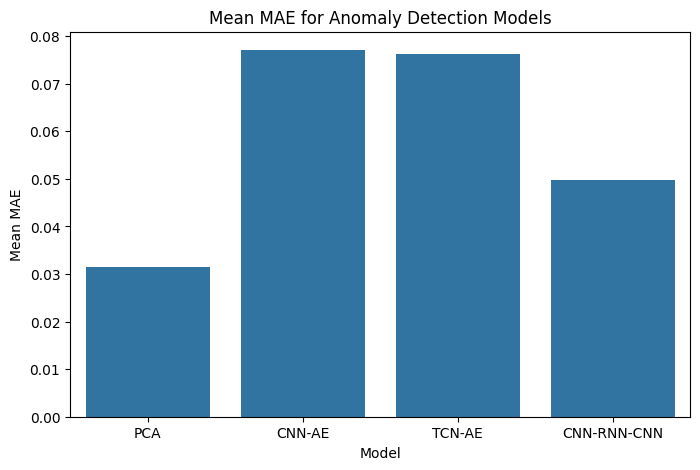

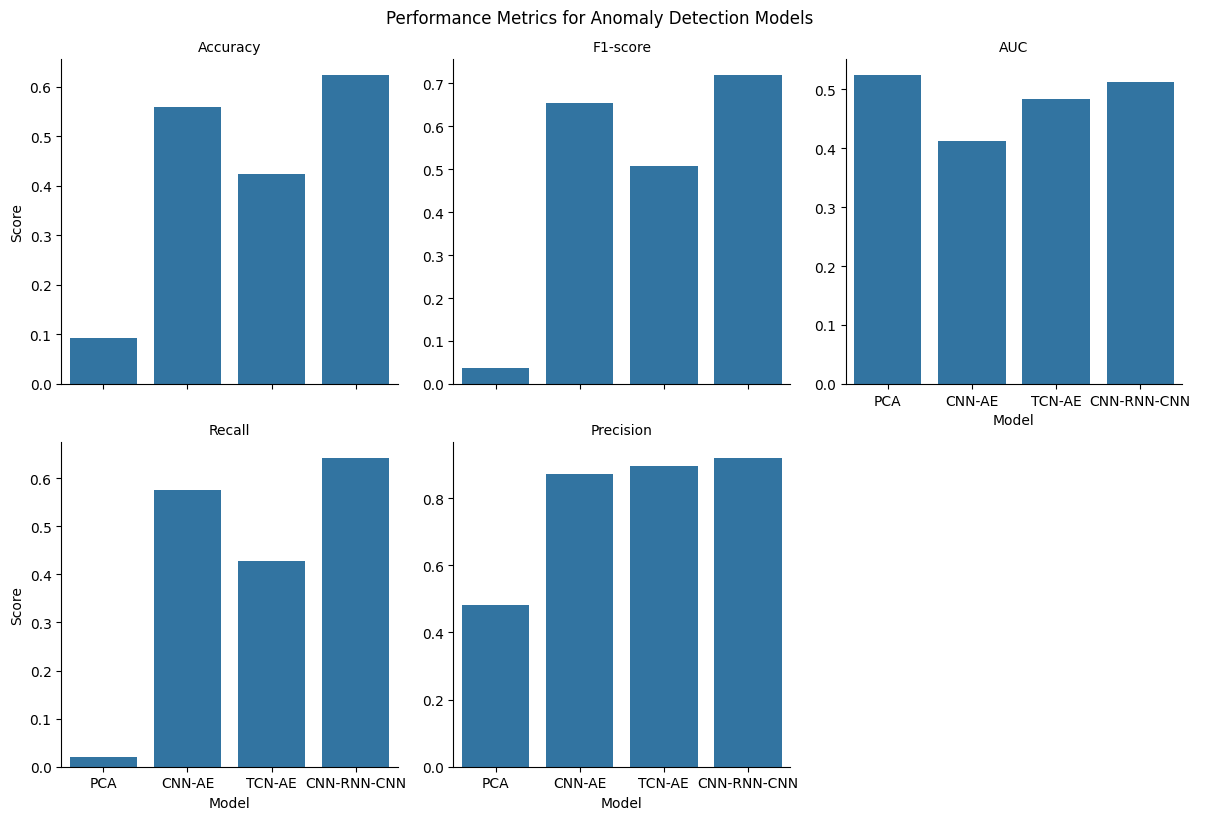

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a table with the mean MAE for each model
mae_data = {
    'Model': ['PCA', 'CNN-AE', 'TCN-AE', 'CNN-RNN-CNN'],
    'Mean MAE': [
        np.mean([m['val_mae'] for m in metrics_pca]),
        np.mean([m['val_mae'] for m in metrics_cnn]),
        np.mean([m['val_mae'] for m in metrics_tcn]),
        np.mean([m['val_mae'] for m in metrics_crnn])
    ]
}
mae_df = pd.DataFrame(mae_data)

print("Mean MAE for each model:")
display(mae_df)

# If labels are available, create a table with other metrics
if HAS_LABELS and 'y_full' in globals() and y_full is not None:
    metrics_data = {
        'Model': ['PCA', 'CNN-AE', 'TCN-AE', 'CNN-RNN-CNN'],
        'Accuracy': [res_pca['acc'], res_cnn['acc'], res_tcn['acc'], res_crnn['acc']],
        'F1-score': [res_pca['f1'], res_cnn['f1'], res_tcn['f1'], res_crnn['f1']],
        'AUC': [res_pca['auc'], res_cnn['auc'], res_tcn['auc'], res_crnn['auc']],
        'Recall': [res_pca['recall'], res_cnn['recall'], res_tcn['recall'], res_crnn['recall']],
        'Precision': [res_pca['precision'], res_cnn['precision'], res_tcn['precision'], res_crnn['precision']]
    }
    metrics_df = pd.DataFrame(metrics_data)

    print("\nOther metrics for each model:")
    display(metrics_df)

# Create a bar chart for mean MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Mean MAE', data=mae_df)
plt.title('Mean MAE for Anomaly Detection Models')
plt.ylabel('Mean MAE')
plt.show()

# If labels are available, create bar charts for other metrics
if HAS_LABELS and 'y_full' in globals() and y_full is not None:
    metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    g = sns.catplot(x='Model', y='Score', col='Metric', data=metrics_df_melted, kind='bar', col_wrap=3, height=4, sharey=False)
    g.fig.suptitle('Performance Metrics for Anomaly Detection Models', y=1.02)
    g.set_titles("{col_name}")
    plt.show()